##Alistamiento de bibliotecas para el proceso##

In [12]:
!pip install pandas numpy matplotlib seaborn nltk spacy transformers torch wordcloud pillow scikit-learn scipy PyPDF2 pdfplumber PyMuPDF
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 60.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import zipfile
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Librerías para procesamiento de texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy

In [4]:
# Librerías para vectorización
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

In [7]:
# Librerías para embeddings
from transformers import AutoTokenizer, AutoModel
import torch

# Librerías para PDFs
import PyPDF2
import pdfplumber
import fitz  # PyMuPDF

In [13]:
# Configuración de visualización
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

In [14]:
def configurar_recursos():
    """Descarga y configura recursos necesarios para español"""
    try:
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)
        nltk.download('punkt_tab', quiet=True)

        # Intentar cargar spacy para español
        try:
            nlp = spacy.load("es_core_news_sm")
            print("✅ SpaCy español cargado correctamente")
        except OSError:
            print("⚠️  Modelo de SpaCy no encontrado. Instalar con: python -m spacy download es_core_news_sm")
            nlp = None

        return nlp
    except Exception as e:
        print(f"❌ Error configurando recursos: {e}")
        return None

nlp = configurar_recursos()


✅ SpaCy español cargado correctamente


In [15]:
# PASO 2: FUNCIONES PARA LEER PDFs
# ============================================================================

def leer_pdf_pdfplumber(ruta_archivo):
    """Lee PDF usando pdfplumber (más robusto para texto)"""
    texto = ""
    try:
        with pdfplumber.open(ruta_archivo) as pdf:
            for pagina in pdf.pages:
                texto_pagina = pagina.extract_text()
                if texto_pagina:
                    texto += texto_pagina + "\n"
        return texto.strip()
    except Exception as e:
        print(f"❌ Error leyendo PDF con pdfplumber: {e}")
        return None

def leer_pdf_pymupdf(ruta_archivo):
    """Lee PDF usando PyMuPDF (alternativo)"""
    texto = ""
    try:
        doc = fitz.open(ruta_archivo)
        for pagina in doc:
            texto += pagina.get_text() + "\n"
        doc.close()
        return texto.strip()
    except Exception as e:
        print(f"❌ Error leyendo PDF con PyMuPDF: {e}")
        return None

def leer_pdf_pypdf2(ruta_archivo):
    """Lee PDF usando PyPDF2 (último recurso)"""
    texto = ""
    try:
        with open(ruta_archivo, 'rb') as archivo:
            lector = PyPDF2.PdfReader(archivo)
            for pagina in lector.pages:
                texto += pagina.extract_text() + "\n"
        return texto.strip()
    except Exception as e:
        print(f"❌ Error leyendo PDF con PyPDF2: {e}")
        return None

def leer_pdf_robusto(ruta_archivo):
    """Intenta leer PDF con múltiples librerías"""
    print(f"📖 Leyendo: {os.path.basename(ruta_archivo)}")

    # Intentar con pdfplumber primero
    texto = leer_pdf_pdfplumber(ruta_archivo)
    if texto and len(texto.strip()) > 100:
        print(f"✅ Leído con pdfplumber ({len(texto)} caracteres)")
        return texto

    # Intentar con PyMuPDF
    texto = leer_pdf_pymupdf(ruta_archivo)
    if texto and len(texto.strip()) > 100:
        print(f"✅ Leído con PyMuPDF ({len(texto)} caracteres)")
        return texto

    # Último recurso: PyPDF2
    texto = leer_pdf_pypdf2(ruta_archivo)
    if texto and len(texto.strip()) > 100:
        print(f"✅ Leído con PyPDF2 ({len(texto)} caracteres)")
        return texto

    print(f"❌ No se pudo leer el archivo correctamente")
    return None

In [16]:
# PASO 3: EXTRAER ARCHIVOS DEL ZIP Y LEER PDFs
# ============================================================================

def extraer_y_leer_discursos(ruta_zip):
    """Extrae archivos del ZIP y lee los PDFs"""
    discursos = {}

    try:
        # Verificar si el archivo ZIP existe
        if not os.path.exists(ruta_zip):
            print(f"❌ No se encuentra el archivo: {ruta_zip}")
            return discursos

        print(f"📦 Extrayendo archivos de: {ruta_zip}")

        with zipfile.ZipFile(ruta_zip, 'r') as zip_ref:
            # Listar archivos en el ZIP
            archivos = zip_ref.namelist()
            archivos_pdf = [f for f in archivos if f.lower().endswith('.pdf')]

            print(f"📄 Encontrados {len(archivos_pdf)} archivos PDF")

            # Crear directorio temporal
            temp_dir = "temp_discursos"
            if not os.path.exists(temp_dir):
                os.makedirs(temp_dir)

            # Extraer y leer cada PDF
            for archivo_pdf in archivos_pdf:
                print(f"\n🔄 Procesando: {archivo_pdf}")

                # Extraer archivo
                zip_ref.extract(archivo_pdf, temp_dir)
                ruta_completa = os.path.join(temp_dir, archivo_pdf)

                # Leer contenido
                texto = leer_pdf_robusto(ruta_completa)

                if texto:
                    # Usar nombre del archivo como clave
                    nombre_limpio = os.path.basename(archivo_pdf).replace('.pdf', '')
                    discursos[nombre_limpio] = texto
                    print(f"✅ Guardado: {nombre_limpio} ({len(texto)} caracteres)")
                else:
                    print(f"❌ No se pudo extraer texto de: {archivo_pdf}")

            # Limpiar archivos temporales
            import shutil
            if os.path.exists(temp_dir):
                shutil.rmtree(temp_dir)

    except Exception as e:
        print(f"❌ Error procesando ZIP: {e}")

    return discursos

# Cargar discursos
print("="*70)
print("PASO 3: CARGA DE DISCURSOS PRESIDENCIALES")
print("="*70)

ruta_zip = "/content/Discursos Presidenciales.zip"
discursos = extraer_y_leer_discursos(ruta_zip)

PASO 3: CARGA DE DISCURSOS PRESIDENCIALES
📦 Extrayendo archivos de: /content/Discursos Presidenciales.zip
📄 Encontrados 4 archivos PDF

🔄 Procesando: Discursos Presidenciales/Alvaro Uribe.pdf
📖 Leyendo: Alvaro Uribe.pdf
✅ Leído con pdfplumber (25865 caracteres)
✅ Guardado: Alvaro Uribe (25865 caracteres)

🔄 Procesando: Discursos Presidenciales/Duque.pdf
📖 Leyendo: Duque.pdf
✅ Leído con pdfplumber (28914 caracteres)
✅ Guardado: Duque (28914 caracteres)

🔄 Procesando: Discursos Presidenciales/Petro.pdf
📖 Leyendo: Petro.pdf
✅ Leído con pdfplumber (23204 caracteres)
✅ Guardado: Petro (23204 caracteres)

🔄 Procesando: Discursos Presidenciales/Santos.pdf
📖 Leyendo: Santos.pdf
✅ Leído con pdfplumber (19788 caracteres)
✅ Guardado: Santos (19788 caracteres)


In [17]:
# PASO 4: PREPROCESAMIENTO (SIN ELIMINAR STOP WORDS AÚN)
# ============================================================================

print("\n" + "="*70)
print("PASO 4: PREPROCESAMIENTO INICIAL")
print("="*70)

def preprocesar_texto_inicial(texto):
    """Preprocesamiento inicial manteniendo números, fechas y stop words"""
    # Convertir a minúsculas
    texto = texto.lower()

    # Limpiar espacios múltiples y saltos de línea
    texto = re.sub(r'\s+', ' ', texto)

    # Eliminar caracteres especiales pero mantener números y fechas
    # Mantenemos letras, números, espacios y algunos signos de puntuación básicos
    texto = re.sub(r'[^\w\s\.,\!\?\;\:\-]', ' ', texto)

    # Limpiar espacios múltiples nuevamente
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto

def tokenizar_texto(texto):
    """Tokeniza el texto usando NLTK"""
    try:
        tokens = word_tokenize(texto, language='spanish')
        # Filtrar tokens muy cortos (menos de 2 caracteres) pero mantener números
        tokens = [token for token in tokens if len(token) >= 2 or token.isdigit()]
        return tokens
    except:
        # Fallback simple
        return texto.split()


PASO 4: PREPROCESAMIENTO INICIAL


In [18]:
# Aplicar preprocesamiento inicial
discursos_preprocesados = {}
tokens_por_discurso = {}

for nombre, texto in discursos.items():
    print(f"\n🔄 Preprocesando: {nombre}")

    # Preprocesamiento
    texto_limpio = preprocesar_texto_inicial(texto)
    discursos_preprocesados[nombre] = texto_limpio

    # Tokenización
    tokens = tokenizar_texto(texto_limpio)
    tokens_por_discurso[nombre] = tokens

    print(f"  - Texto original: {len(texto)} caracteres")
    print(f"  - Texto limpio: {len(texto_limpio)} caracteres")
    print(f"  - Tokens: {len(tokens)}")
    print(f"  - Primeros tokens: {tokens[:10]}")


🔄 Preprocesando: Alvaro Uribe
  - Texto original: 25865 caracteres
  - Texto limpio: 25856 caracteres
  - Tokens: 3827
  - Primeros tokens: ['21.', 'discurso', 'de', 'álvaro', 'uribe', 'en', 'la', 'posesión', 'presidencial', 'periodo']

🔄 Preprocesando: Duque
  - Texto original: 28914 caracteres
  - Texto limpio: 28905 caracteres
  - Tokens: 4208
  - Primeros tokens: ['el', 'pacto', 'por', 'colombia', 'discurso', 'de', 'posesión', 'del', 'presidente', 'de']

🔄 Preprocesando: Petro
  - Texto original: 23204 caracteres
  - Texto limpio: 23172 caracteres
  - Tokens: 3583
  - Primeros tokens: ['llegar', 'aquí', 'indudablemente', 'implica', 'recorrer', 'una', 'vida', 'la', 'vida', 'inmensa']

🔄 Preprocesando: Santos
  - Texto original: 19788 caracteres
  - Texto limpio: 19575 caracteres
  - Tokens: 3100
  - Primeros tokens: ['7', 'de', 'agosto', 'del', '2014', 'bogotá', 'd.', 'c.', 'presidente', 'de']


In [19]:
# PASO 5: ANÁLISIS DE STOP WORDS
# ============================================================================

print("\n" + "="*70)
print("PASO 5: ANÁLISIS DE STOP WORDS")
print("="*70)

# Cargar stop words en español
try:
    stop_words_es = set(stopwords.words('spanish'))
    print(f"✅ Cargadas {len(stop_words_es)} stop words en español")
except:
    # Stop words básicas en español como fallback
    stop_words_es = set(['el', 'la', 'de', 'que', 'y', 'a', 'en', 'un', 'es', 'se',
                        'no', 'te', 'lo', 'le', 'da', 'su', 'por', 'son', 'con',
                        'para', 'al', 'del', 'los', 'las', 'una', 'como', 'más',
                        'pero', 'sus', 'me', 'hasta', 'donde', 'quien', 'desde',
                        'todos', 'estas', 'este', 'esta', 'todo', 'muy', 'ser'])
    print(f"⚠️ Usando stop words básicas ({len(stop_words_es)} palabras)")

def analizar_stop_words(tokens, stop_words):
    """Analiza las stop words en una lista de tokens"""
    stop_words_encontradas = [token for token in tokens if token.lower() in stop_words]
    contador_stop_words = Counter(stop_words_encontradas)

    stats = {
        'total_tokens': len(tokens),
        'stop_words_count': len(stop_words_encontradas),
        'stop_words_unique': len(set(stop_words_encontradas)),
        'stop_words_percentage': (len(stop_words_encontradas) / len(tokens)) * 100,
        'counter': contador_stop_words,
        'stop_words_list': stop_words_encontradas
    }

    return stats

# Analizar stop words en cada discurso
analisis_stop_words = {}

for nombre, tokens in tokens_por_discurso.items():
    print(f"\n🔍 Analizando stop words en: {nombre}")

    stats = analizar_stop_words(tokens, stop_words_es)
    analisis_stop_words[nombre] = stats

    print(f"  - Total tokens: {stats['total_tokens']}")
    print(f"  - Stop words: {stats['stop_words_count']} ({stats['stop_words_percentage']:.1f}%)")
    print(f"  - Stop words únicas: {stats['stop_words_unique']}")
    print(f"  - Top 5 stop words: {stats['counter'].most_common(5)}")


PASO 5: ANÁLISIS DE STOP WORDS
✅ Cargadas 313 stop words en español

🔍 Analizando stop words en: Alvaro Uribe
  - Total tokens: 3827
  - Stop words: 1698 (44.4%)
  - Stop words únicas: 90
  - Top 5 stop words: [('de', 296), ('la', 270), ('el', 160), ('en', 122), ('que', 100)]

🔍 Analizando stop words en: Duque
  - Total tokens: 4208
  - Stop words: 1887 (44.8%)
  - Stop words únicas: 106
  - Top 5 stop words: [('de', 250), ('la', 223), ('que', 159), ('el', 129), ('en', 102)]

🔍 Analizando stop words en: Petro
  - Total tokens: 3583
  - Stop words: 1703 (47.5%)
  - Stop words únicas: 112
  - Top 5 stop words: [('de', 211), ('la', 188), ('que', 130), ('el', 90), ('en', 81)]

🔍 Analizando stop words en: Santos
  - Total tokens: 3100
  - Stop words: 1402 (45.2%)
  - Stop words únicas: 109
  - Top 5 stop words: [('de', 173), ('que', 135), ('la', 115), ('en', 75), ('los', 67)]



PASO 6: VISUALIZACIÓN DE ANÁLISIS DE STOP WORDS


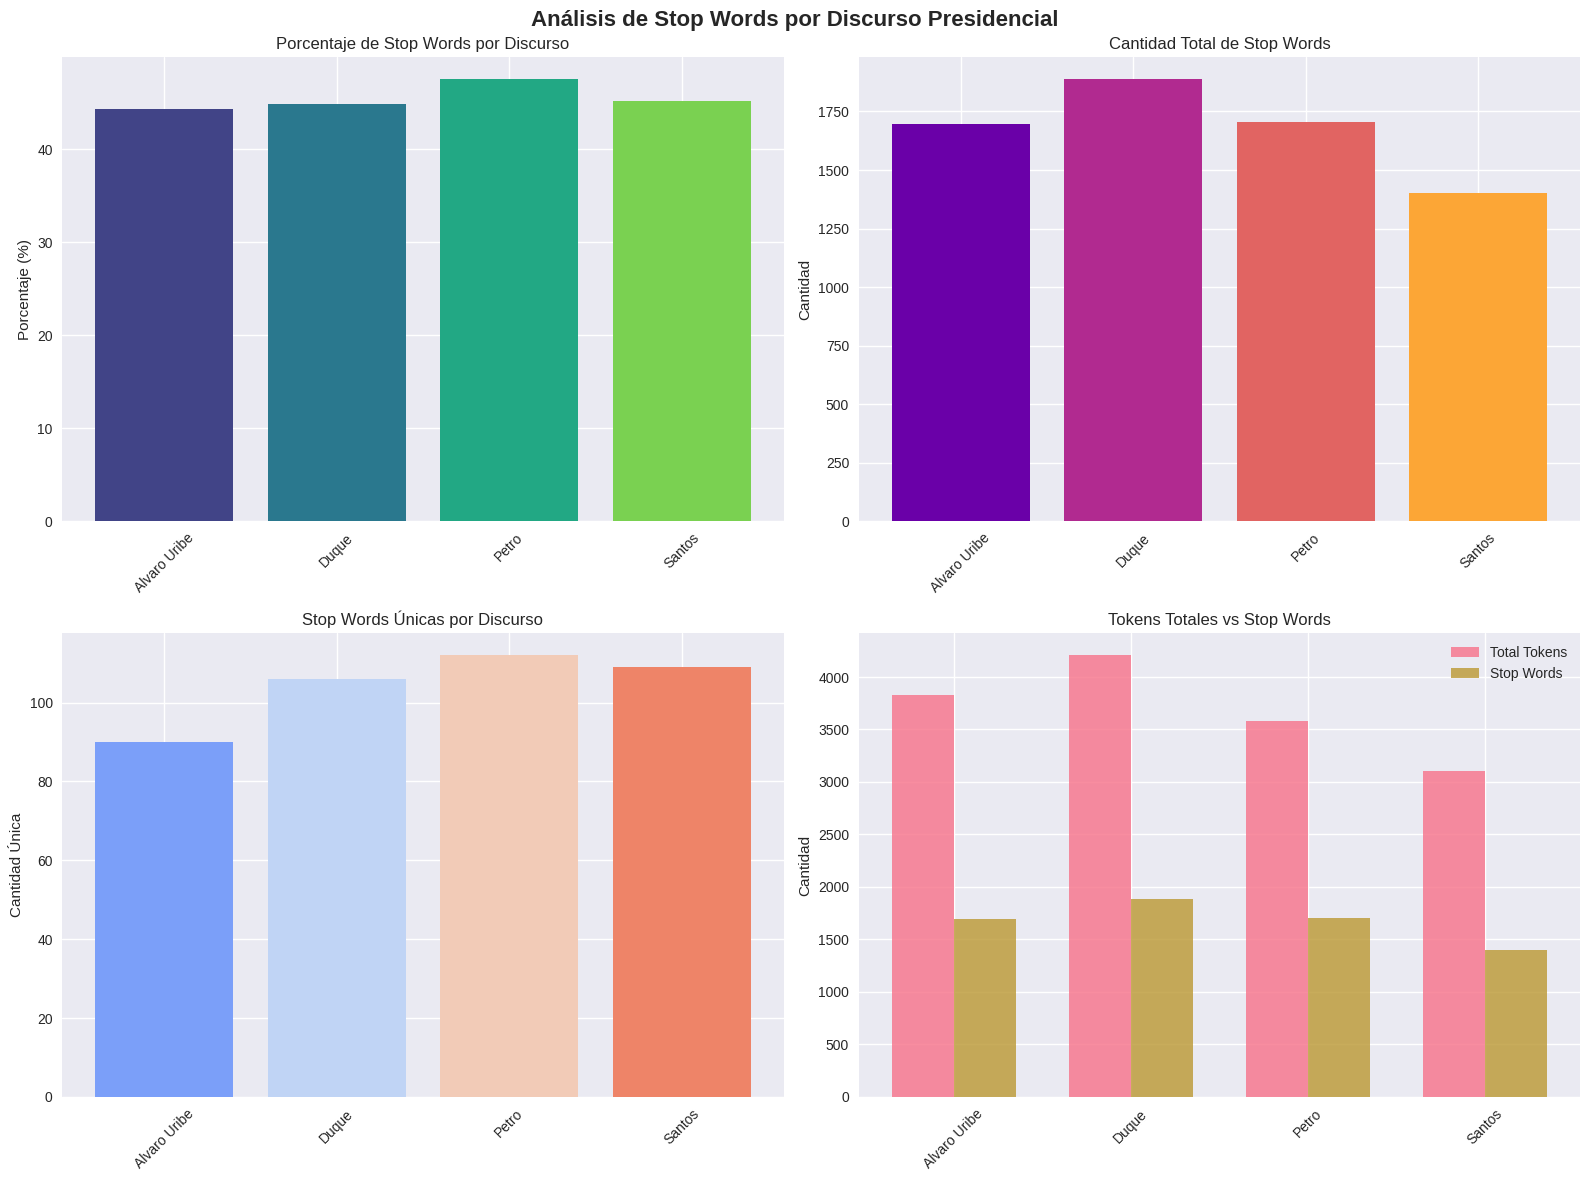


📊 TABLA RESUMEN - ANÁLISIS DE STOP WORDS:
    Discurso  Total_Tokens  Stop_Words  Stop_Words_Unicas Porcentaje_Stop_Words
Alvaro Uribe          3827        1698                 90                 44.4%
       Duque          4208        1887                106                 44.8%
       Petro          3583        1703                112                 47.5%
      Santos          3100        1402                109                 45.2%

🔝 TOP 10 STOP WORDS POR DISCURSO:

Alvaro Uribe:
   1. de           (296 veces)
   2. la           (270 veces)
   3. el           (160 veces)
   4. en           (122 veces)
   5. que          (100 veces)
   6. con          ( 75 veces)
   7. los          ( 58 veces)
   8. del          ( 53 veces)
   9. para         ( 46 veces)
  10. las          ( 43 veces)

Duque:
   1. de           (250 veces)
   2. la           (223 veces)
   3. que          (159 veces)
   4. el           (129 veces)
   5. en           (102 veces)
   6. los          ( 99 veces)
   

In [20]:
# PASO 6: VISUALIZACIÓN DE STOP WORDS
# ============================================================================

print("\n" + "="*70)
print("PASO 6: VISUALIZACIÓN DE ANÁLISIS DE STOP WORDS")
print("="*70)

# Crear visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis de Stop Words por Discurso Presidencial', fontsize=16, fontweight='bold')

# Gráfico 1: Porcentaje de stop words
nombres = list(analisis_stop_words.keys())
porcentajes = [analisis_stop_words[nombre]['stop_words_percentage'] for nombre in nombres]

axes[0,0].bar(nombres, porcentajes, color=sns.color_palette("viridis", len(nombres)))
axes[0,0].set_title('Porcentaje de Stop Words por Discurso')
axes[0,0].set_ylabel('Porcentaje (%)')
axes[0,0].tick_params(axis='x', rotation=45)

# Gráfico 2: Cantidad total de stop words
cantidades = [analisis_stop_words[nombre]['stop_words_count'] for nombre in nombres]

axes[0,1].bar(nombres, cantidades, color=sns.color_palette("plasma", len(nombres)))
axes[0,1].set_title('Cantidad Total de Stop Words')
axes[0,1].set_ylabel('Cantidad')
axes[0,1].tick_params(axis='x', rotation=45)

# Gráfico 3: Stop words únicas
unicas = [analisis_stop_words[nombre]['stop_words_unique'] for nombre in nombres]

axes[1,0].bar(nombres, unicas, color=sns.color_palette("coolwarm", len(nombres)))
axes[1,0].set_title('Stop Words Únicas por Discurso')
axes[1,0].set_ylabel('Cantidad Única')
axes[1,0].tick_params(axis='x', rotation=45)

# Gráfico 4: Comparación total de tokens vs stop words
width = 0.35
x = np.arange(len(nombres))
totales = [analisis_stop_words[nombre]['total_tokens'] for nombre in nombres]

axes[1,1].bar(x - width/2, totales, width, label='Total Tokens', alpha=0.8)
axes[1,1].bar(x + width/2, cantidades, width, label='Stop Words', alpha=0.8)
axes[1,1].set_title('Tokens Totales vs Stop Words')
axes[1,1].set_ylabel('Cantidad')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(nombres, rotation=45)
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Crear tabla resumen
print("\n📊 TABLA RESUMEN - ANÁLISIS DE STOP WORDS:")
print("="*80)
df_stop_words = pd.DataFrame({
    'Discurso': nombres,
    'Total_Tokens': [analisis_stop_words[nombre]['total_tokens'] for nombre in nombres],
    'Stop_Words': [analisis_stop_words[nombre]['stop_words_count'] for nombre in nombres],
    'Stop_Words_Unicas': [analisis_stop_words[nombre]['stop_words_unique'] for nombre in nombres],
    'Porcentaje_Stop_Words': [f"{analisis_stop_words[nombre]['stop_words_percentage']:.1f}%" for nombre in nombres]
})

print(df_stop_words.to_string(index=False))

# Mostrar las top stop words por discurso
print(f"\n🔝 TOP 10 STOP WORDS POR DISCURSO:")
print("="*50)

for nombre in nombres:
    print(f"\n{nombre}:")
    top_words = analisis_stop_words[nombre]['counter'].most_common(10)
    for i, (word, count) in enumerate(top_words, 1):
        print(f"  {i:2d}. {word:12s} ({count:3d} veces)")


In [21]:
# PASO 7: ELIMINACIÓN DE STOP WORDS
# ============================================================================

print("\n" + "="*70)
print("PASO 7: ELIMINACIÓN DE STOP WORDS")
print("="*70)

def eliminar_stop_words(tokens, stop_words):
    """Elimina stop words de una lista de tokens"""
    tokens_filtrados = [token for token in tokens if token.lower() not in stop_words]
    return tokens_filtrados

# Aplicar eliminación de stop words
tokens_sin_stop_words = {}

for nombre, tokens in tokens_por_discurso.items():
    print(f"\n🧹 Eliminando stop words de: {nombre}")

    tokens_originales = len(tokens)
    tokens_filtrados = eliminar_stop_words(tokens, stop_words_es)
    tokens_sin_stop_words[nombre] = tokens_filtrados

    tokens_finales = len(tokens_filtrados)
    reduccion = ((tokens_originales - tokens_finales) / tokens_originales) * 100

    print(f"  - Tokens originales: {tokens_originales}")
    print(f"  - Tokens finales: {tokens_finales}")
    print(f"  - Reducción: {reduccion:.1f}%")
    print(f"  - Primeros tokens filtrados: {tokens_filtrados[:10]}")

# Crear textos limpios (sin stop words) para vectorización
textos_limpios = {}
for nombre, tokens in tokens_sin_stop_words.items():
    textos_limpios[nombre] = ' '.join(tokens)

print(f"\n✅ Textos procesados y listos para vectorización")


PASO 7: ELIMINACIÓN DE STOP WORDS

🧹 Eliminando stop words de: Alvaro Uribe
  - Tokens originales: 3827
  - Tokens finales: 2129
  - Reducción: 44.4%
  - Primeros tokens filtrados: ['21.', 'discurso', 'álvaro', 'uribe', 'posesión', 'presidencial', 'periodo', '2006', '2010', '07']

🧹 Eliminando stop words de: Duque
  - Tokens originales: 4208
  - Tokens finales: 2321
  - Reducción: 44.8%
  - Primeros tokens filtrados: ['pacto', 'colombia', 'discurso', 'posesión', 'presidente', 'república', 'colombia', 'iván', 'duque', 'márquez']

🧹 Eliminando stop words de: Petro
  - Tokens originales: 3583
  - Tokens finales: 1880
  - Reducción: 47.5%
  - Primeros tokens filtrados: ['llegar', 'aquí', 'indudablemente', 'implica', 'recorrer', 'vida', 'vida', 'inmensa', 'nunca', 'recorre']

🧹 Eliminando stop words de: Santos
  - Tokens originales: 3100
  - Tokens finales: 1698
  - Reducción: 45.2%
  - Primeros tokens filtrados: ['7', 'agosto', '2014', 'bogotá', 'd.', 'c.', 'presidente', 'república', 'jua


PASO 8: VECTORIZACIÓN - MÉTODO 1: TF-IDF
✅ Matriz TF-IDF creada:
  - Dimensiones: (4, 1000)
  - Características: 1000
  - Tipo de matriz: <class 'scipy.sparse._csr.csr_matrix'>

🔝 TOP 10 CARACTERÍSTICAS TF-IDF POR DISCURSO:

Alvaro Uribe:
   1. confianza            (0.2381)
   2. equilibrio           (0.1877)
   3. libertades           (0.1690)
   4. crecimiento          (0.1672)
   5. popular              (0.1520)
   6. congreso             (0.1502)
   7. comunidad            (0.1502)
   8. equidad              (0.1368)
   9. democrática          (0.1368)
  10. generosidad          (0.1191)

Duque:
   1. legalidad            (0.2771)
   2. quiero               (0.2040)
   3. equidad              (0.1904)
   4. pacto                (0.1848)
   5. bicentenario         (0.1492)
   6. principios           (0.1492)
   7. regiones             (0.1360)
   8. emprendimiento       (0.1279)
   9. corrupción           (0.1224)
  10. condiciones          (0.1066)

Petro:
   1. aquí              

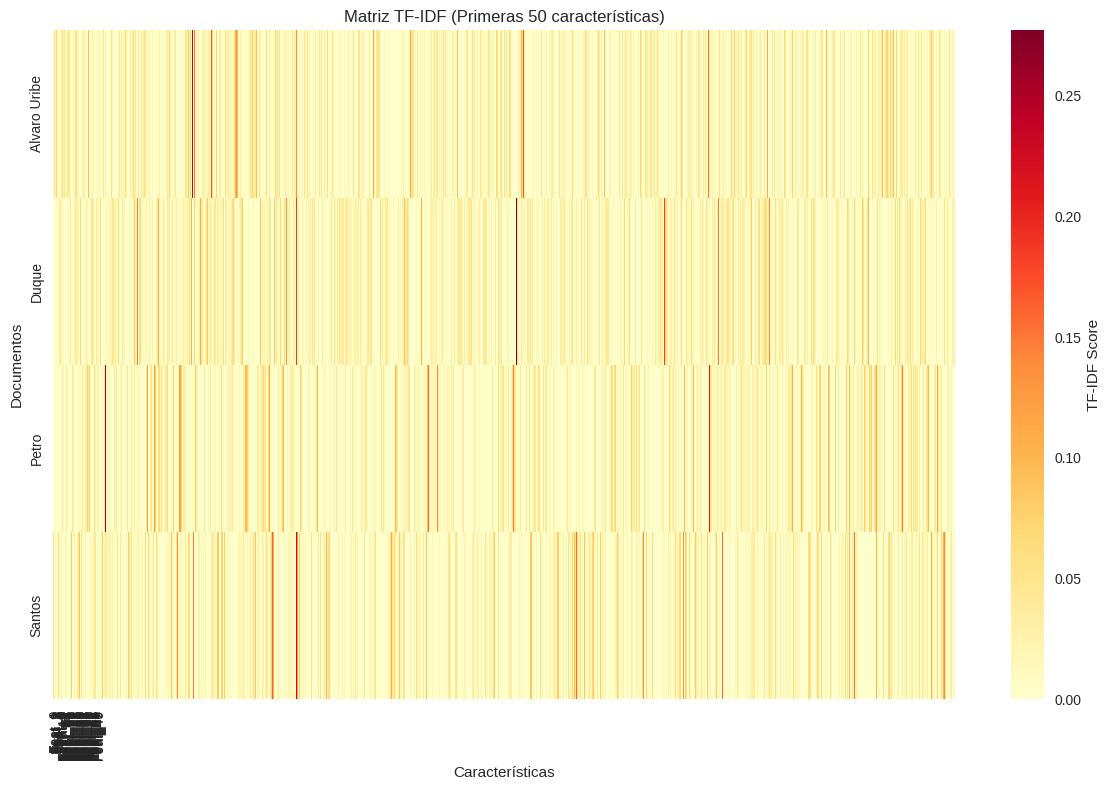

In [22]:
# PASO 8: VECTORIZACIÓN - MÉTODO 1: TF-IDF
# ============================================================================

print("\n" + "="*70)
print("PASO 8: VECTORIZACIÓN - MÉTODO 1: TF-IDF")
print("="*70)

# Preparar datos para TF-IDF
nombres_ordenados = list(textos_limpios.keys())
corpus = [textos_limpios[nombre] for nombre in nombres_ordenados]

# Crear vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  # Top 1000 características
    ngram_range=(1, 2),  # Unigramas y bigramas
    min_df=1,  # Mínimo en 1 documento
    max_df=0.8  # Máximo en 80% de documentos
)

# Aplicar TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

print(f"✅ Matriz TF-IDF creada:")
print(f"  - Dimensiones: {tfidf_matrix.shape}")
print(f"  - Características: {len(feature_names_tfidf)}")
print(f"  - Tipo de matriz: {type(tfidf_matrix)}")

# Convertir a array denso para análisis
tfidf_dense = tfidf_matrix.toarray()

# Mostrar características más importantes por documento
print(f"\n🔝 TOP 10 CARACTERÍSTICAS TF-IDF POR DISCURSO:")
print("="*60)

for i, nombre in enumerate(nombres_ordenados):
    print(f"\n{nombre}:")

    # Obtener puntuaciones TF-IDF para este documento
    tfidf_scores = tfidf_dense[i]

    # Encontrar top características
    top_indices = np.argsort(tfidf_scores)[-10:][::-1]

    for j, idx in enumerate(top_indices, 1):
        if tfidf_scores[idx] > 0:
            print(f"  {j:2d}. {feature_names_tfidf[idx]:20s} ({tfidf_scores[idx]:.4f})")

# Visualizar matriz TF-IDF
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_dense,
            xticklabels=[f"Feat_{i}" for i in range(min(50, len(feature_names_tfidf)))],
            yticklabels=nombres_ordenados,
            cmap='YlOrRd',
            cbar_kws={'label': 'TF-IDF Score'})
plt.title('Matriz TF-IDF (Primeras 50 características)')
plt.xlabel('Características')
plt.ylabel('Documentos')
plt.tight_layout()
plt.show()


PASO 8: VECTORIZACIÓN - MÉTODO 1: TF-IDF
✅ Matriz TF-IDF creada:
  - Dimensiones: (4, 1000)
  - Características: 1000
  - Tipo de matriz: <class 'scipy.sparse._csr.csr_matrix'>

🔝 TOP 10 CARACTERÍSTICAS TF-IDF POR DISCURSO:

Alvaro Uribe:
   1. confianza            (0.2381)
   2. equilibrio           (0.1877)
   3. libertades           (0.1690)
   4. crecimiento          (0.1672)
   5. popular              (0.1520)
   6. congreso             (0.1502)
   7. comunidad            (0.1502)
   8. equidad              (0.1368)
   9. democrática          (0.1368)
  10. generosidad          (0.1191)

Duque:
   1. legalidad            (0.2771)
   2. quiero               (0.2040)
   3. equidad              (0.1904)
   4. pacto                (0.1848)
   5. bicentenario         (0.1492)
   6. principios           (0.1492)
   7. regiones             (0.1360)
   8. emprendimiento       (0.1279)
   9. corrupción           (0.1224)
  10. condiciones          (0.1066)

Petro:
   1. aquí              

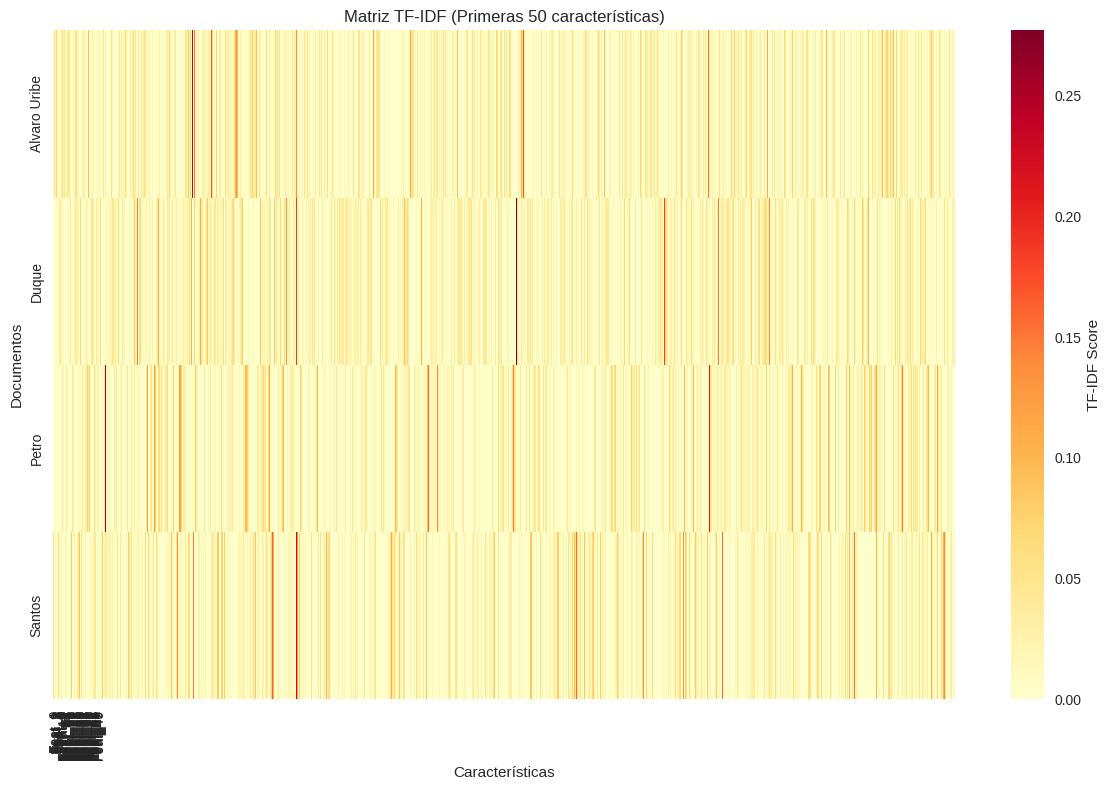

In [23]:
print("\n" + "="*70)
print("PASO 8: VECTORIZACIÓN - MÉTODO 1: TF-IDF")
print("="*70)

# Preparar datos para TF-IDF
nombres_ordenados = list(textos_limpios.keys())
corpus = [textos_limpios[nombre] for nombre in nombres_ordenados]

# Crear vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,  # Top 1000 características
    ngram_range=(1, 2),  # Unigramas y bigramas
    min_df=1,  # Mínimo en 1 documento
    max_df=0.8  # Máximo en 80% de documentos
)

# Aplicar TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

print(f"✅ Matriz TF-IDF creada:")
print(f"  - Dimensiones: {tfidf_matrix.shape}")
print(f"  - Características: {len(feature_names_tfidf)}")
print(f"  - Tipo de matriz: {type(tfidf_matrix)}")

# Convertir a array denso para análisis
tfidf_dense = tfidf_matrix.toarray()

# Mostrar características más importantes por documento
print(f"\n🔝 TOP 10 CARACTERÍSTICAS TF-IDF POR DISCURSO:")
print("="*60)

for i, nombre in enumerate(nombres_ordenados):
    print(f"\n{nombre}:")

    # Obtener puntuaciones TF-IDF para este documento
    tfidf_scores = tfidf_dense[i]

    # Encontrar top características
    top_indices = np.argsort(tfidf_scores)[-10:][::-1]

    for j, idx in enumerate(top_indices, 1):
        if tfidf_scores[idx] > 0:
            print(f"  {j:2d}. {feature_names_tfidf[idx]:20s} ({tfidf_scores[idx]:.4f})")

# Visualizar matriz TF-IDF
plt.figure(figsize=(12, 8))
sns.heatmap(tfidf_dense,
            xticklabels=[f"Feat_{i}" for i in range(min(50, len(feature_names_tfidf)))],
            yticklabels=nombres_ordenados,
            cmap='YlOrRd',
            cbar_kws={'label': 'TF-IDF Score'})
plt.title('Matriz TF-IDF (Primeras 50 características)')
plt.xlabel('Características')
plt.ylabel('Documentos')
plt.tight_layout()
plt.show()


PASO 9: VECTORIZACIÓN - MÉTODO 2: ONE-HOT ENCODING
✅ Matriz One-Hot creada:
  - Dimensiones: (4, 1000)
  - Características: 1000
  - Valores únicos: [0 1]

📊 ESTADÍSTICAS ONE-HOT ENCODING:
Alvaro Uribe:
  - Características presentes: 602/1000
  - Porcentaje de características: 60.2%
  - Primeras palabras presentes: ['07', '08', '15', '20', '200', '2003', '2006', '2010', '2019', 'abusos']

Duque:
  - Características presentes: 636/1000
  - Porcentaje de características: 63.6%
  - Primeras palabras presentes: ['17', '2018', '2019', '300', 'abandono', 'abuelo', 'abusos', 'acceso', 'acciones', 'acción']

Petro:
  - Características presentes: 564/1000
  - Porcentaje de características: 56.4%
  - Primeras palabras presentes: ['10', '200', 'abuelo', 'acción', 'aceptar', 'actos', 'acuerdo', 'acuerdos', 'acá', 'adelante']

Santos:
  - Características presentes: 523/1000
  - Porcentaje de características: 52.3%
  - Primeras palabras presentes: ['100', '15', '195', '200', '2014', '300', 'abandon

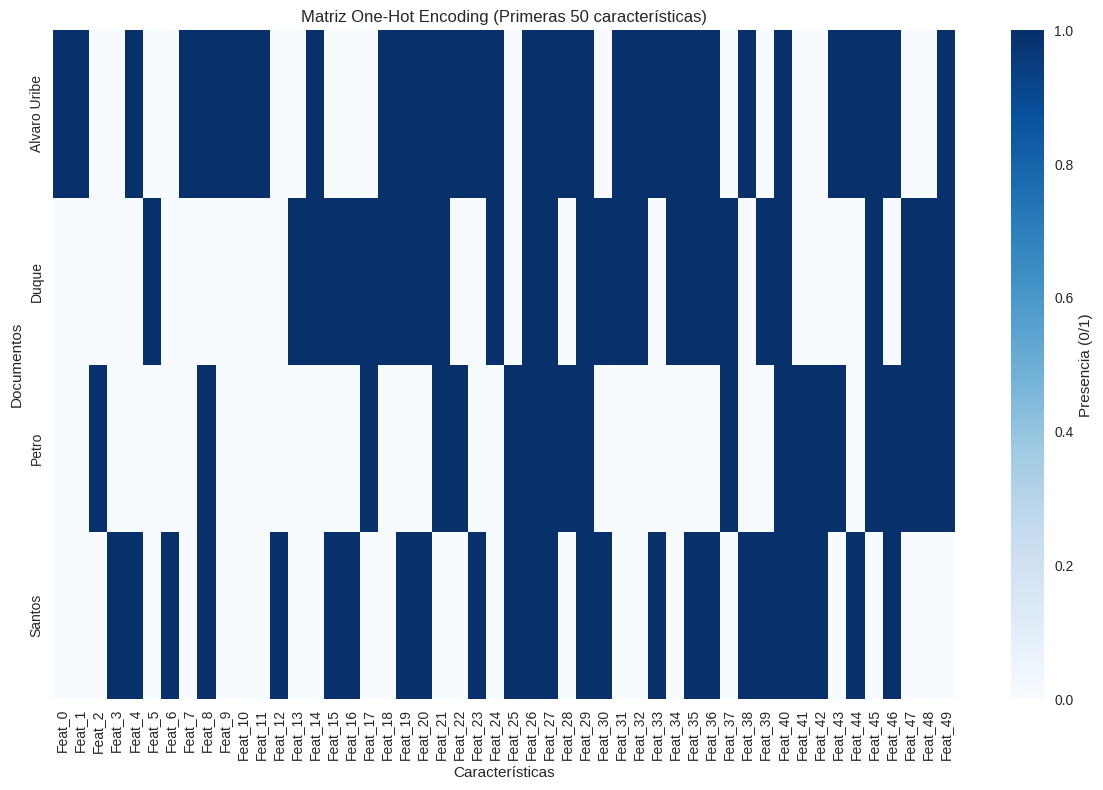

In [24]:
# PASO 9: VECTORIZACIÓN - MÉTODO 2: ONE-HOT ENCODING
# ============================================================================

print("\n" + "="*70)
print("PASO 9: VECTORIZACIÓN - MÉTODO 2: ONE-HOT ENCODING")
print("="*70)

# Crear vectorizador One-Hot (CountVectorizer con binary=True)
onehot_vectorizer = CountVectorizer(
    max_features=1000,
    binary=True,  # Esto hace que sea One-Hot (0 o 1)
    ngram_range=(1, 1),  # Solo unigramas para One-Hot
    min_df=1
)

# Aplicar One-Hot Encoding
onehot_matrix = onehot_vectorizer.fit_transform(corpus)
feature_names_onehot = onehot_vectorizer.get_feature_names_out()

print(f"✅ Matriz One-Hot creada:")
print(f"  - Dimensiones: {onehot_matrix.shape}")
print(f"  - Características: {len(feature_names_onehot)}")
print(f"  - Valores únicos: {np.unique(onehot_matrix.toarray())}")

# Convertir a array denso
onehot_dense = onehot_matrix.toarray()

# Mostrar estadísticas de One-Hot
print(f"\n📊 ESTADÍSTICAS ONE-HOT ENCODING:")
print("="*50)

for i, nombre in enumerate(nombres_ordenados):
    presencia = np.sum(onehot_dense[i])
    total_features = len(feature_names_onehot)
    porcentaje = (presencia / total_features) * 100

    print(f"{nombre}:")
    print(f"  - Características presentes: {presencia}/{total_features}")
    print(f"  - Porcentaje de características: {porcentaje:.1f}%")

    # Mostrar algunas características presentes
    indices_presentes = np.where(onehot_dense[i] == 1)[0][:10]
    palabras_presentes = [feature_names_onehot[idx] for idx in indices_presentes]
    print(f"  - Primeras palabras presentes: {palabras_presentes}")
    print()

# Visualizar matriz One-Hot
plt.figure(figsize=(12, 8))
sns.heatmap(onehot_dense[:, :50],  # Primeras 50 características
            xticklabels=[f"Feat_{i}" for i in range(min(50, len(feature_names_onehot)))],
            yticklabels=nombres_ordenados,
            cmap='Blues',
            cbar_kws={'label': 'Presencia (0/1)'})
plt.title('Matriz One-Hot Encoding (Primeras 50 características)')
plt.xlabel('Características')
plt.ylabel('Documentos')
plt.tight_layout()
plt.show()


PASO 10: VECTORIZACIÓN - MÉTODO 3: EMBEDDINGS CON TRANSFORMER
🤖 Cargando modelo transformer: distilbert-base-multilingual-cased


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

🔄 Procesando texto 1/4...
🔄 Procesando texto 2/4...
🔄 Procesando texto 3/4...
🔄 Procesando texto 4/4...
✅ Embeddings creados: (4, 768)

📊 ESTADÍSTICAS EMBEDDINGS:
Dimensiones: (4, 768)
Rango de valores: [-3.1589, 3.2495]
Media: -0.0005
Desviación estándar: 0.3828


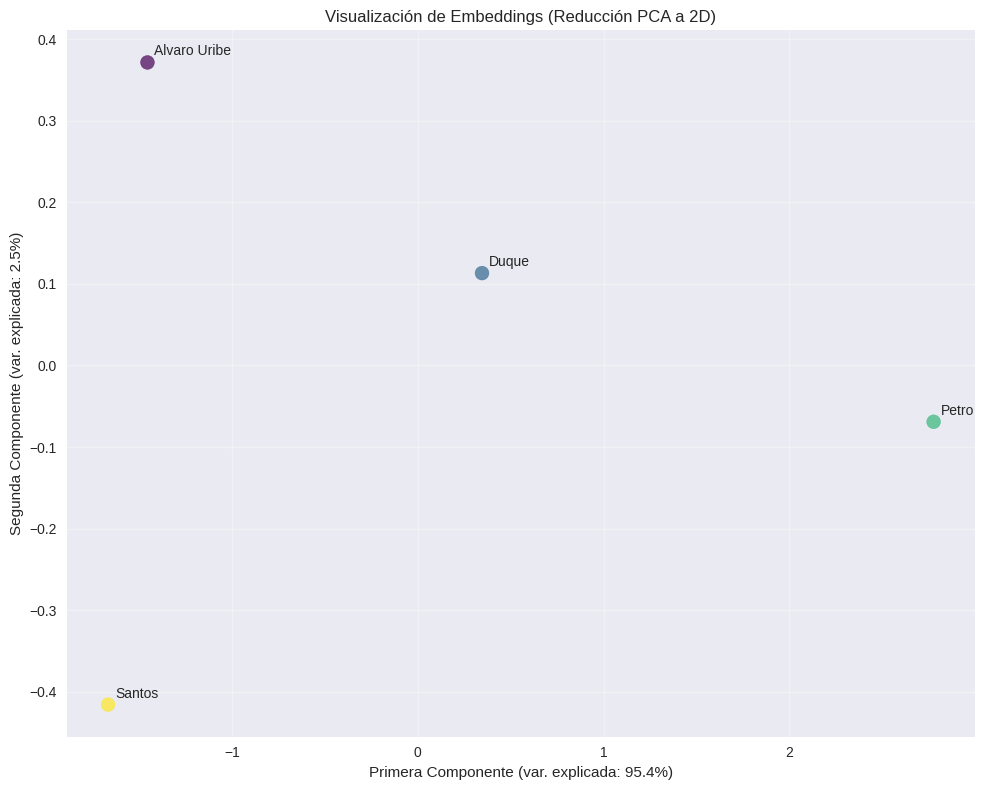

In [25]:
# PASO 10: VECTORIZACIÓN - MÉTODO 3: EMBEDDINGS CON TRANSFORMER
# ============================================================================

print("\n" + "="*70)
print("PASO 10: VECTORIZACIÓN - MÉTODO 3: EMBEDDINGS CON TRANSFORMER")
print("="*70)

def crear_embeddings_transformer(textos, modelo_nombre='distilbert-base-multilingual-cased'):
    """Crea embeddings usando un modelo transformer multilingüe"""
    try:
        print(f"🤖 Cargando modelo transformer: {modelo_nombre}")

        # Cargar tokenizer y modelo
        tokenizer = AutoTokenizer.from_pretrained(modelo_nombre)
        model = AutoModel.from_pretrained(modelo_nombre)

        embeddings = []

        for i, texto in enumerate(textos):
            print(f"🔄 Procesando texto {i+1}/{len(textos)}...")

            # Tokenizar (limitando longitud)
            inputs = tokenizer(texto,
                             return_tensors='pt',
                             truncation=True,
                             padding=True,
                             max_length=512)

            # Obtener embeddings
            with torch.no_grad():
                outputs = model(**inputs)
                # Usar el embedding del token [CLS] como representación del documento
                embedding = outputs.last_hidden_state[:, 0, :].numpy()
                embeddings.append(embedding.flatten())

        embeddings_array = np.array(embeddings)
        print(f"✅ Embeddings creados: {embeddings_array.shape}")

        return embeddings_array

    except Exception as e:
        print(f"❌ Error con transformer: {e}")
        print("🔄 Creando embeddings sintéticos como fallback...")
        return crear_embeddings_fallback(textos)

def crear_embeddings_fallback(textos):
    """Crea embeddings sintéticos basados en TF-IDF como fallback"""
    # Usar TF-IDF con más características para simular embeddings
    fallback_vectorizer = TfidfVectorizer(max_features=300, ngram_range=(1, 2))
    embeddings = fallback_vectorizer.fit_transform(textos).toarray()

    print(f"⚠️ Usando embeddings sintéticos: {embeddings.shape}")
    return embeddings

# Crear embeddings
corpus_para_embeddings = [textos_limpios[nombre] for nombre in nombres_ordenados]
embeddings_matrix = crear_embeddings_transformer(corpus_para_embeddings)

print(f"\n📊 ESTADÍSTICAS EMBEDDINGS:")
print("="*40)
print(f"Dimensiones: {embeddings_matrix.shape}")
print(f"Rango de valores: [{embeddings_matrix.min():.4f}, {embeddings_matrix.max():.4f}]")
print(f"Media: {embeddings_matrix.mean():.4f}")
print(f"Desviación estándar: {embeddings_matrix.std():.4f}")

# Visualizar embeddings (usando PCA para reducir dimensionalidad)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_matrix)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                     s=100, alpha=0.7, c=range(len(nombres_ordenados)), cmap='viridis')

# Añadir etiquetas
for i, nombre in enumerate(nombres_ordenados):
    plt.annotate(nombre, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                xytext=(5, 5), textcoords='offset points', fontsize=10)

plt.title('Visualización de Embeddings (Reducción PCA a 2D)')
plt.xlabel(f'Primera Componente (var. explicada: {pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'Segunda Componente (var. explicada: {pca.explained_variance_ratio_[1]:.1%})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


PASO 11: NUBES DE PALABRAS PERSONALIZADAS POR PRESIDENTE
🔍 Identificando presidentes en los archivos:
  - Alvaro Uribe → Álvaro Uribe Vélez
  - Duque → Iván Duque Márquez
  - Petro → Gustavo Petro Urrego
  - Santos → Juan Manuel Santos

☁️ Creando nubes de palabras personalizadas:
  🎨 Creando nube para: Álvaro Uribe Vélez
  🎨 Creando nube para: Iván Duque Márquez
  🎨 Creando nube para: Gustavo Petro Urrego
  🎨 Creando nube para: Juan Manuel Santos


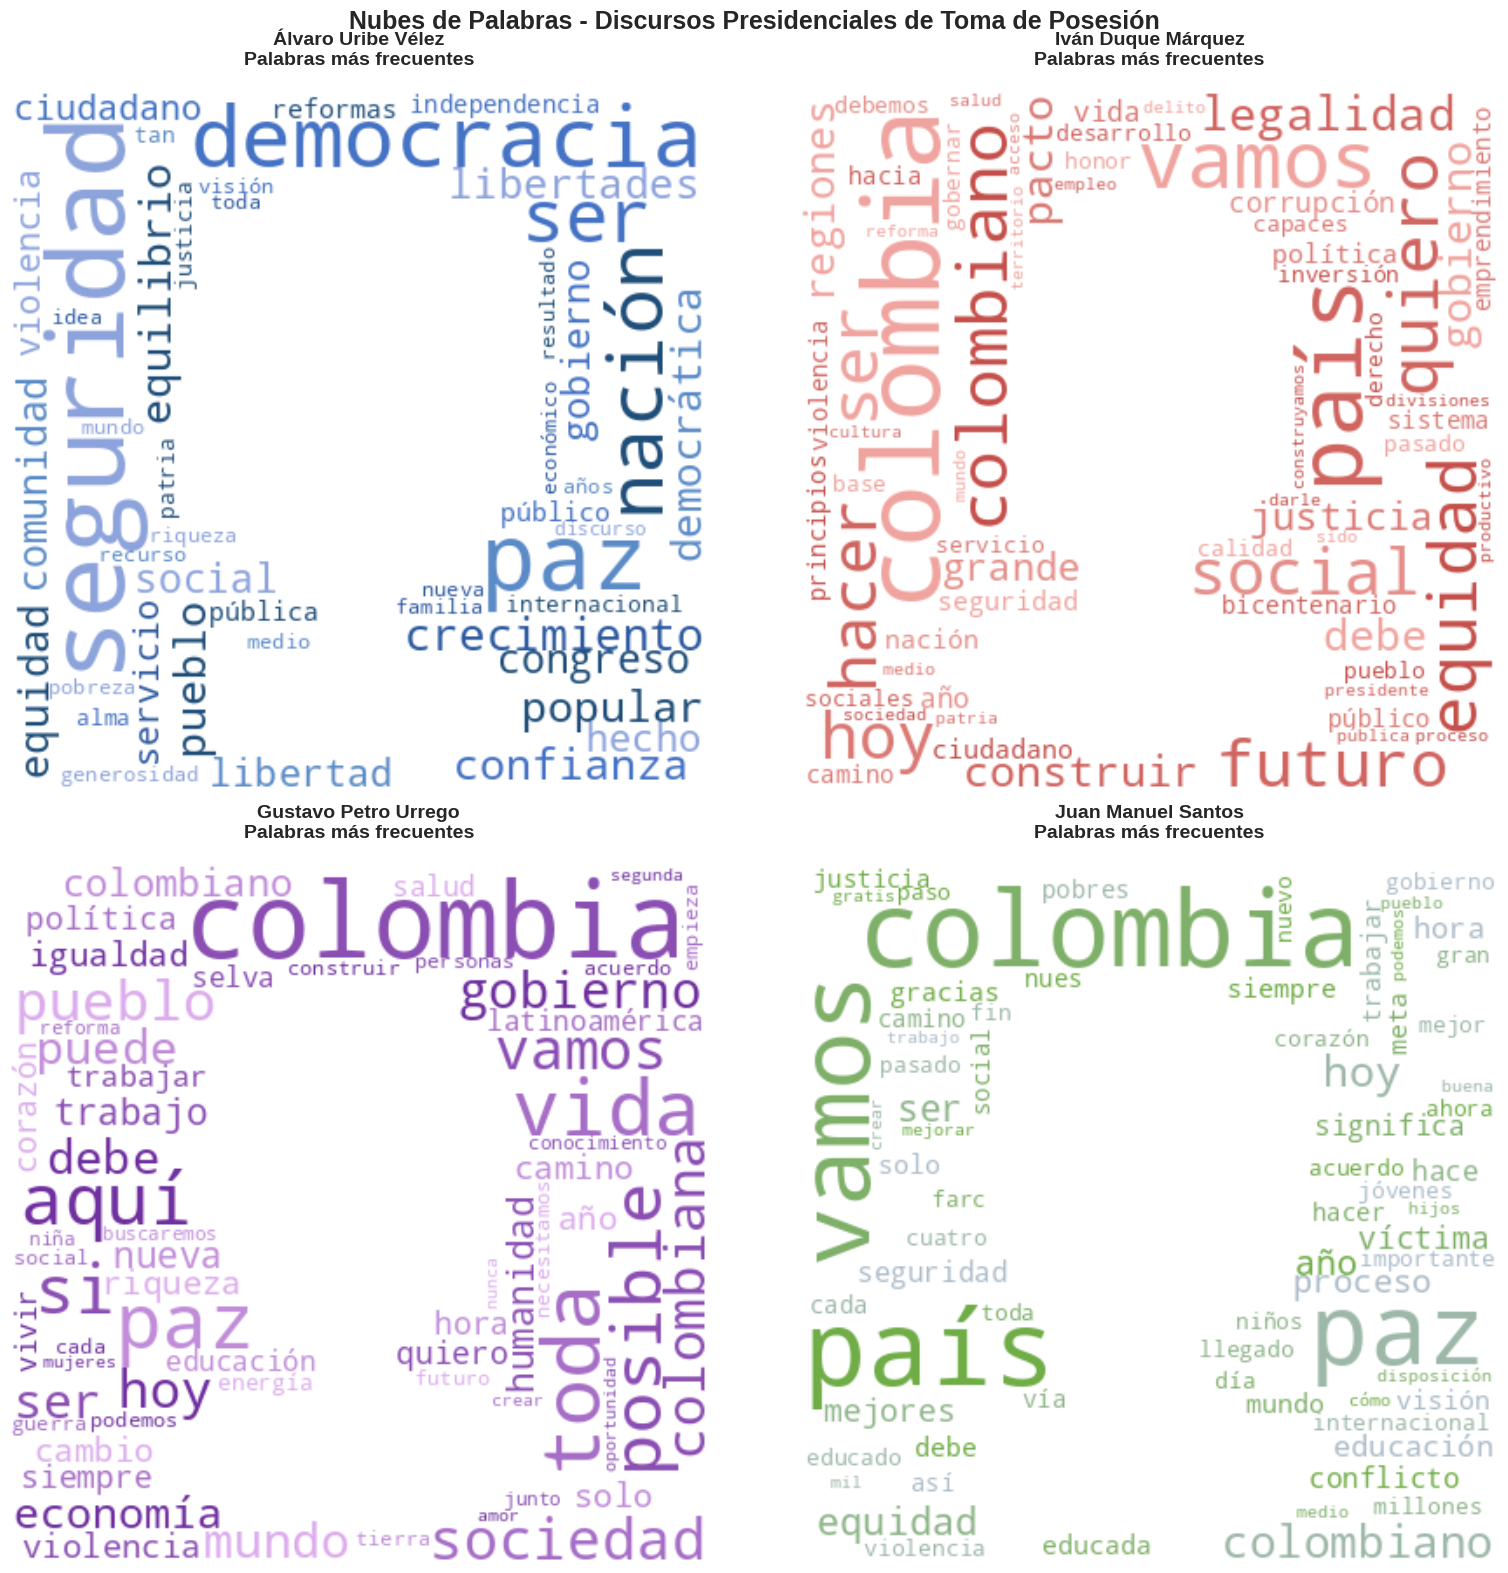

In [26]:
# PASO 11: NUBES DE PALABRAS PERSONALIZADAS POR PRESIDENTE
# ============================================================================

print("\n" + "="*70)
print("PASO 11: NUBES DE PALABRAS PERSONALIZADAS POR PRESIDENTE")
print("="*70)

from wordcloud import WordCloud
from PIL import Image, ImageDraw
import numpy as np

def identificar_presidente(nombre_archivo):
    """Identifica el presidente basado en el nombre del archivo"""
    nombre_lower = nombre_archivo.lower()

    if 'uribe' in nombre_lower:
        return 'Álvaro Uribe Vélez', 'uribe'
    elif 'duque' in nombre_lower:
        return 'Iván Duque Márquez', 'duque'
    elif 'santos' in nombre_lower:
        return 'Juan Manuel Santos', 'santos'
    elif 'petro' in nombre_lower:
        return 'Gustavo Petro Urrego', 'petro'
    else:
        # Intentar identificar por patrones comunes
        if any(x in nombre_lower for x in ['gustavo', 'petro']):
            return 'Gustavo Petro Urrego', 'petro'
        elif any(x in nombre_lower for x in ['ivan', 'duque']):
            return 'Iván Duque Márquez', 'duque'
        elif any(x in nombre_lower for x in ['juan', 'manuel', 'santos']):
            return 'Juan Manuel Santos', 'santos'
        elif any(x in nombre_lower for x in ['alvaro', 'uribe']):
            return 'Álvaro Uribe Vélez', 'uribe'
        else:
            return nombre_archivo, 'generico'

def crear_silueta_presidente(presidente_key, tamaño=(400, 400)):
    """Crea una silueta característica para cada presidente"""
    img = Image.new('L', tamaño, 0)  # Imagen en escala de grises
    draw = ImageDraw.Draw(img)

    if presidente_key == 'uribe':
        # Silueta de perfil con características distintivas
        # Cabeza ovalada con énfasis en la frente
        draw.ellipse([100, 50, 300, 280], fill=255)
        # Cuello
        draw.rectangle([180, 260, 220, 350], fill=255)
        # Hombros
        draw.ellipse([120, 320, 280, 380], fill=255)

    elif presidente_key == 'duque':
        # Silueta más joven, cara ovalada
        draw.ellipse([120, 60, 280, 260], fill=255)
        # Cuello
        draw.rectangle([180, 240, 220, 320], fill=255)
        # Hombros anchos
        draw.ellipse([100, 300, 300, 370], fill=255)

    elif presidente_key == 'santos':
        # Silueta con características distintivas
        draw.ellipse([110, 70, 290, 270], fill=255)
        # Cuello
        draw.rectangle([180, 250, 220, 330], fill=255)
        # Hombros
        draw.ellipse([110, 310, 290, 380], fill=255)

    elif presidente_key == 'petro':
        # Silueta característica
        draw.ellipse([115, 65, 285, 265], fill=255)
        # Cuello
        draw.rectangle([180, 245, 220, 325], fill=255)
        # Hombros
        draw.ellipse([105, 305, 295, 375], fill=255)

    else:
        # Silueta genérica
        draw.ellipse([120, 70, 280, 270], fill=255)
        draw.rectangle([180, 250, 220, 330], fill=255)
        draw.ellipse([110, 310, 290, 380], fill=255)

    return np.array(img)

def crear_nube_palabras_personalizada(texto, presidente_nombre, presidente_key):
    """Crea una nube de palabras con silueta personalizada"""

    # Configurar colores por presidente
    colores_por_presidente = {
        'uribe': ['#1f4e79', '#2d5aa0', '#4472c4', '#5b8bc7', '#8da3db'],
        'duque': ['#c5504b', '#d06560', '#da7a75', '#e58f8a', '#f0a49f'],
        'santos': ['#70ad47', '#7fb069', '#8eb489', '#9db8a9', '#acbcc9'],
        'petro': ['#7030a0', '#8b4fb3', '#a66ec6', '#c18dd9', '#dcacec']
    }

    def color_func(*args, **kwargs):
        colores = colores_por_presidente.get(presidente_key, ['#333333', '#666666', '#999999'])
        return np.random.choice(colores)

    try:
        # Crear silueta
        mask = crear_silueta_presidente(presidente_key)

        # Configurar WordCloud
        wordcloud = WordCloud(
            width=400,
            height=400,
            background_color='white',
            mask=mask,
            max_words=100,
            relative_scaling=0.5,
            min_font_size=10,
            max_font_size=60,
            color_func=color_func,
            collocations=False,
            prefer_horizontal=0.9
        )

        # Generar nube de palabras
        wordcloud.generate(texto)

        return wordcloud, mask

    except Exception as e:
        print(f"❌ Error creando nube de palabras para {presidente_nombre}: {e}")

        # Fallback sin máscara
        wordcloud = WordCloud(
            width=400,
            height=400,
            background_color='white',
            max_words=100,
            color_func=color_func,
            collocations=False
        )
        wordcloud.generate(texto)
        return wordcloud, None

# Identificar presidentes y crear nubes de palabras
presidentes_info = {}

print("🔍 Identificando presidentes en los archivos:")
for nombre_archivo, tokens in tokens_sin_stop_words.items():
    presidente_completo, presidente_key = identificar_presidente(nombre_archivo)

    presidentes_info[nombre_archivo] = {
        'nombre_completo': presidente_completo,
        'key': presidente_key,
        'tokens': tokens,
        'texto': ' '.join(tokens)
    }

    print(f"  - {nombre_archivo} → {presidente_completo}")

# Crear las nubes de palabras
print(f"\n☁️ Creando nubes de palabras personalizadas:")

# Configurar el plot
num_presidentes = len(presidentes_info)
cols = 2
rows = (num_presidentes + 1) // 2

fig, axes = plt.subplots(rows, cols, figsize=(16, 8 * rows))
if rows == 1:
    axes = [axes] if cols == 1 else axes
else:
    axes = axes.flatten()

# Ocultar ejes extra si es necesario
for i in range(num_presidentes, len(axes)):
    axes[i].axis('off')

# Crear cada nube de palabras
for i, (nombre_archivo, info) in enumerate(presidentes_info.items()):
    print(f"  🎨 Creando nube para: {info['nombre_completo']}")

    # Crear nube de palabras
    wordcloud, mask = crear_nube_palabras_personalizada(
        info['texto'],
        info['nombre_completo'],
        info['key']
    )

    # Mostrar en subplot
    ax = axes[i] if len(axes) > 1 else axes
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"{info['nombre_completo']}\nPalabras más frecuentes",
                fontsize=14, fontweight='bold', pad=20)
    ax.axis('off')

plt.suptitle('Nubes de Palabras - Discursos Presidenciales de Toma de Posesión',
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()


📊 ANÁLISIS ESTADÍSTICO DE NUBES DE PALABRAS:

Álvaro Uribe Vélez:
  - Palabras únicas: 1465
  - Palabras que aparecen solo una vez: 1130
  - Top 10 palabras más frecuentes:
     1. seguridad       ( 22 veces)
     2. paz             ( 17 veces)
     3. democracia      ( 15 veces)
     4. nación          ( 12 veces)
     5. ser             ( 11 veces)
     6. crecimiento     ( 11 veces)
     7. equilibrio      ( 10 veces)
     8. confianza       ( 10 veces)
     9. popular         ( 10 veces)
    10. equidad         (  9 veces)

Iván Duque Márquez:
  - Palabras únicas: 1401
  - Palabras que aparecen solo una vez: 1029
  - Top 10 palabras más frecuentes:
     1. colombia        ( 38 veces)
     2. país            ( 27 veces)
     3. vamos           ( 22 veces)
     4. quiero          ( 15 veces)
     5. ser             ( 15 veces)
     6. equidad         ( 14 veces)
     7. hoy             ( 13 veces)
     8. futuro          ( 13 veces)
     9. social          ( 13 veces)
    10. hacer 

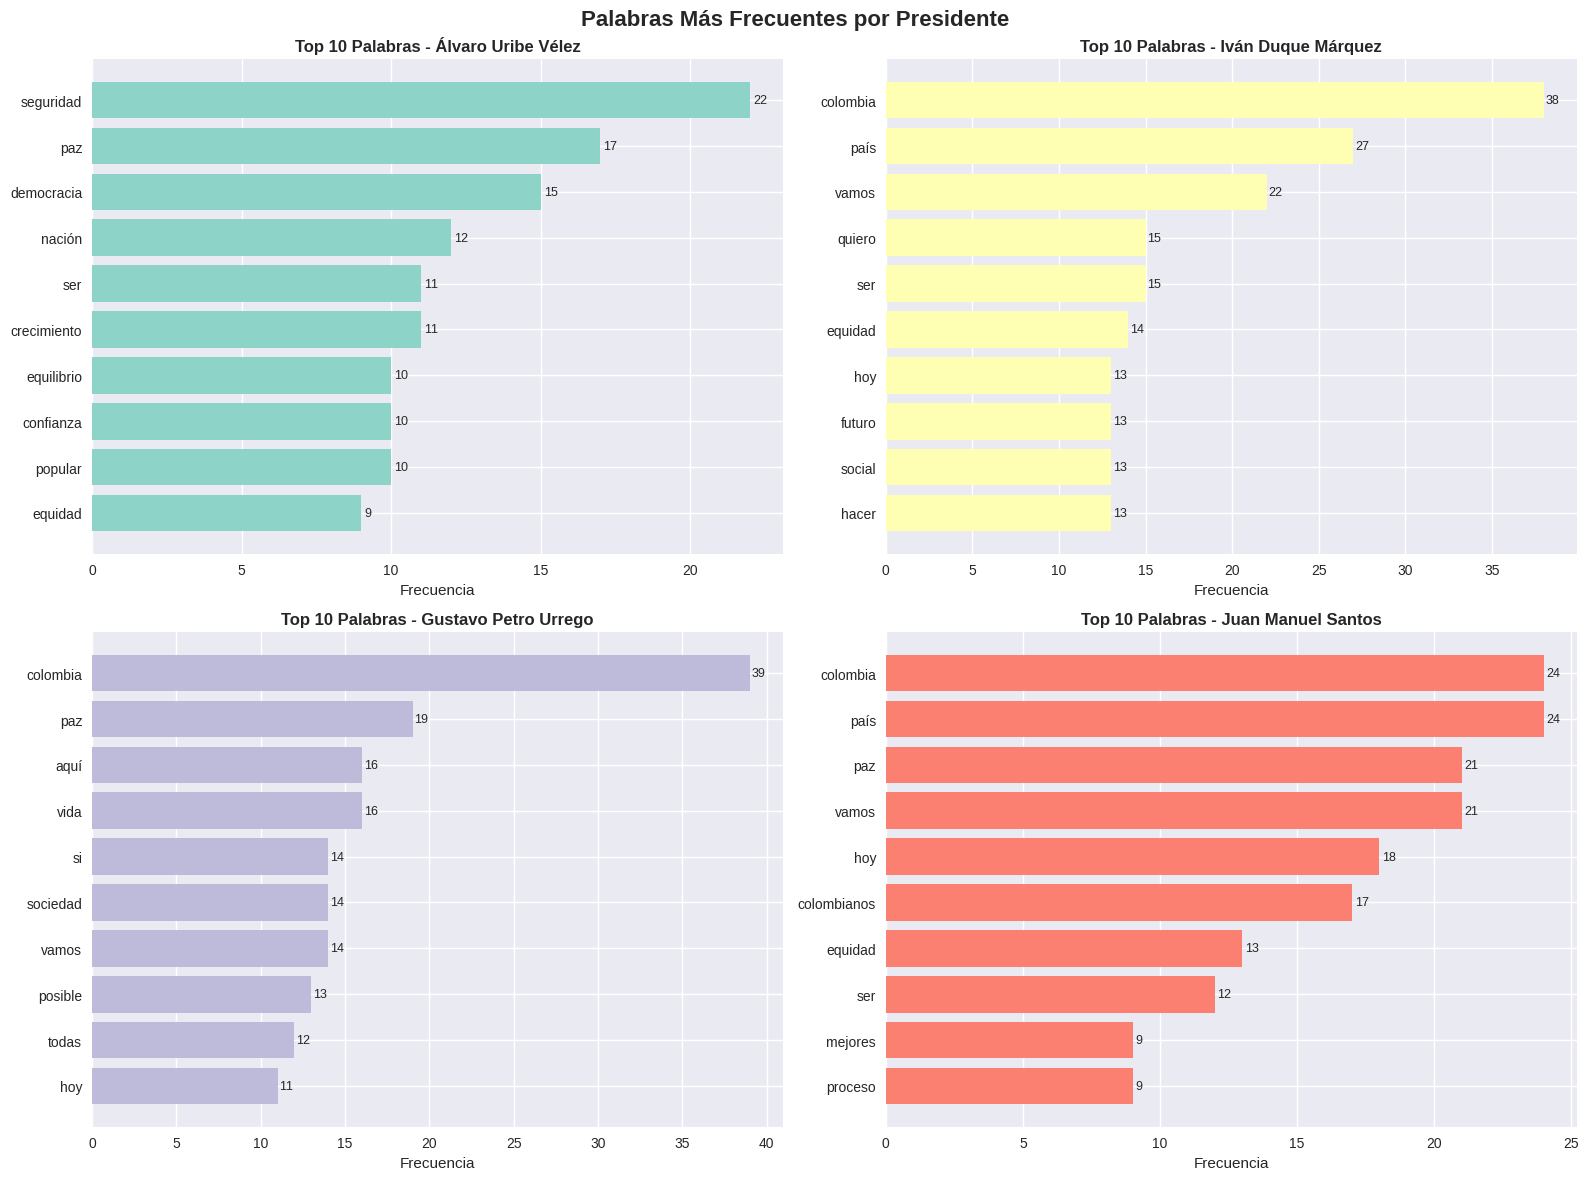

In [27]:
# Crear análisis estadístico de las nubes de palabras
print(f"\n📊 ANÁLISIS ESTADÍSTICO DE NUBES DE PALABRAS:")
print("="*70)

palabras_stats = {}
for nombre_archivo, info in presidentes_info.items():
    # Contar palabras más frecuentes
    contador_palabras = Counter(info['tokens'])
    top_20 = contador_palabras.most_common(20)

    palabras_stats[info['nombre_completo']] = {
        'total_palabras_unicas': len(contador_palabras),
        'top_20': top_20,
        'palabras_una_vez': sum(1 for count in contador_palabras.values() if count == 1)
    }

    print(f"\n{info['nombre_completo']}:")
    print(f"  - Palabras únicas: {palabras_stats[info['nombre_completo']]['total_palabras_unicas']}")
    print(f"  - Palabras que aparecen solo una vez: {palabras_stats[info['nombre_completo']]['palabras_una_vez']}")
    print(f"  - Top 10 palabras más frecuentes:")

    for j, (palabra, frecuencia) in enumerate(top_20[:10], 1):
        print(f"    {j:2d}. {palabra:15s} ({frecuencia:3d} veces)")

# Crear gráfico comparativo de palabras más frecuentes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (presidente, stats) in enumerate(palabras_stats.items()):
    if i < 4:  # Máximo 4 presidentes
        palabras = [item[0] for item in stats['top_20'][:10]]
        frecuencias = [item[1] for item in stats['top_20'][:10]]

        axes[i].barh(range(len(palabras)), frecuencias,
                    color=plt.cm.Set3(i))
        axes[i].set_yticks(range(len(palabras)))
        axes[i].set_yticklabels(palabras)
        axes[i].set_xlabel('Frecuencia')
        axes[i].set_title(f'Top 10 Palabras - {presidente}', fontweight='bold')
        axes[i].invert_yaxis()

        # Añadir valores en las barras
        for j, freq in enumerate(frecuencias):
            axes[i].text(freq + 0.1, j, str(freq),
                        va='center', fontsize=9)

plt.suptitle('Palabras Más Frecuentes por Presidente', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


PASO 12: ANÁLISIS DE SIMILITUD - COSENO Y CORRELACIÓN DE PEARSON

🔍 Analizando similitudes con TF-IDF...

📊 TF-IDF:
Similitud del Coseno:
              Alvaro Uribe   Duque   Petro  Santos
Alvaro Uribe        1.0000  0.2265  0.1642  0.1986
Duque               0.2265  1.0000  0.1792  0.2535
Petro               0.1642  0.1792  1.0000  0.1796
Santos              0.1986  0.2535  0.1796  1.0000

Correlación de Pearson:
              Alvaro Uribe   Duque   Petro  Santos
Alvaro Uribe        1.0000 -0.1384 -0.1924 -0.1275
Duque              -0.1384  1.0000 -0.1885 -0.0650
Petro              -0.1924 -0.1885  1.0000 -0.1377
Santos             -0.1275 -0.0650 -0.1377  1.0000


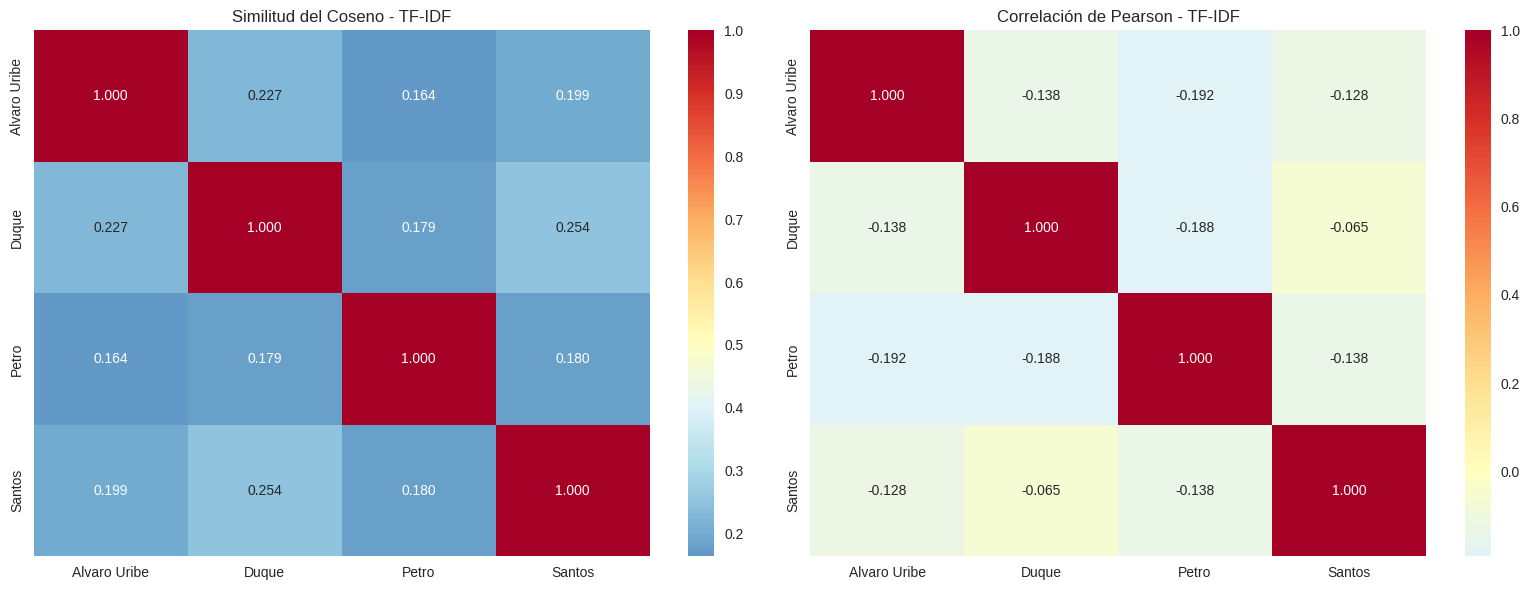


🔍 Analizando similitudes con One-Hot Encoding...

📊 ONE-HOT ENCODING:
Similitud del Coseno:
              Alvaro Uribe   Duque   Petro  Santos
Alvaro Uribe        1.0000  0.5883  0.5320  0.5311
Duque               0.5883  1.0000  0.5644  0.5479
Petro               0.5320  0.5644  1.0000  0.5266
Santos              0.5311  0.5479  0.5266  1.0000

Correlación de Pearson:
              Alvaro Uribe   Duque   Petro  Santos
Alvaro Uribe        1.0000 -0.0801 -0.1216 -0.0689
Duque              -0.0801  1.0000 -0.0868 -0.0692
Petro              -0.1216 -0.0868  1.0000 -0.0362
Santos             -0.0689 -0.0692 -0.0362  1.0000


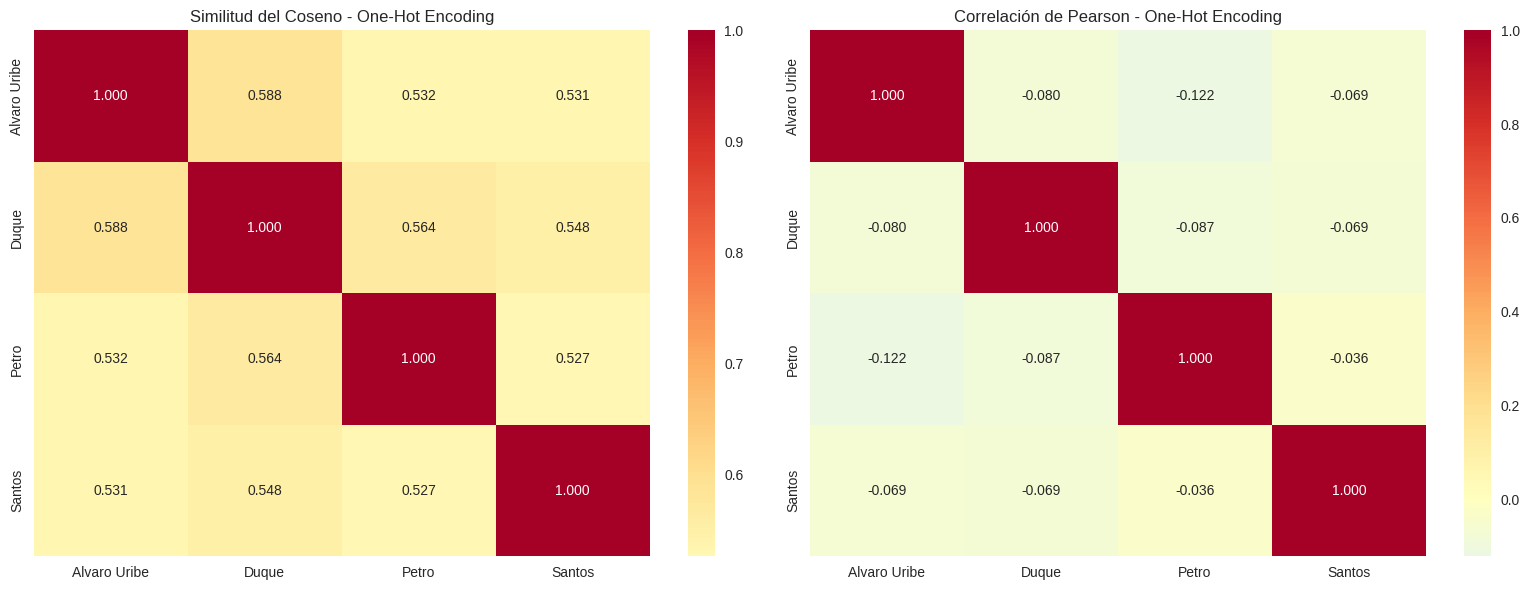


🔍 Analizando similitudes con Embeddings...

📊 EMBEDDINGS:
Similitud del Coseno:
              Alvaro Uribe   Duque   Petro  Santos
Alvaro Uribe        1.0000  0.9870  0.9310  0.9974
Duque               0.9870  1.0000  0.9730  0.9851
Petro               0.9310  0.9730  1.0000  0.9269
Santos              0.9974  0.9851  0.9269  1.0000

Correlación de Pearson:
              Alvaro Uribe   Duque   Petro  Santos
Alvaro Uribe        1.0000  0.9870  0.9311  0.9974
Duque               0.9870  1.0000  0.9730  0.9851
Petro               0.9311  0.9730  1.0000  0.9269
Santos              0.9974  0.9851  0.9269  1.0000


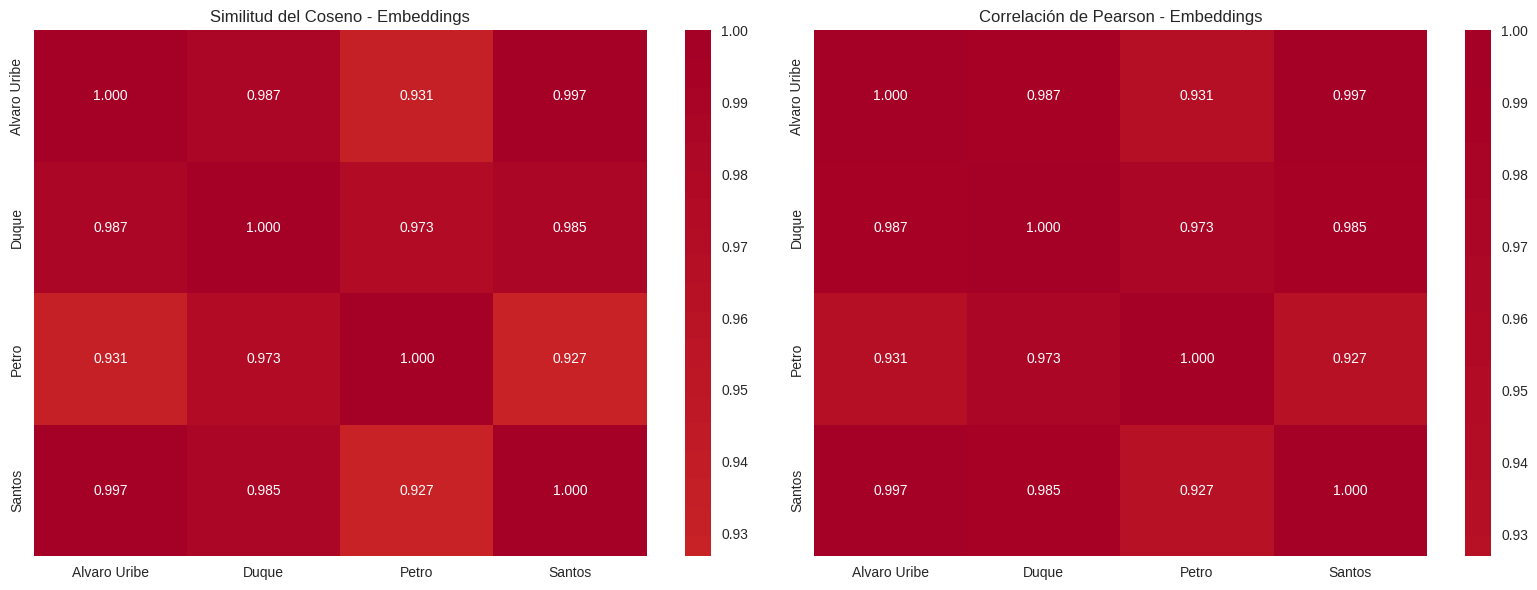

In [28]:
# PASO 12: ANÁLISIS DE SIMILITUD - COSENO Y CORRELACIÓN DE PEARSON
# ============================================================================

print("\n" + "="*70)
print("PASO 12: ANÁLISIS DE SIMILITUD - COSENO Y CORRELACIÓN DE PEARSON")
print("="*70)

def calcular_similitudes(matriz, nombres, metodo_nombre):
    """Calcula similitud del coseno y correlación de Pearson"""

    # Similitud del coseno
    similitud_coseno = cosine_similarity(matriz)

    # Correlación de Pearson
    correlacion_pearson = np.corrcoef(matriz)

    print(f"\n📊 {metodo_nombre.upper()}:")
    print("="*50)

    # Mostrar matrices
    print(f"Similitud del Coseno:")
    df_coseno = pd.DataFrame(similitud_coseno,
                           index=nombres,
                           columns=nombres)
    print(df_coseno.round(4))

    print(f"\nCorrelación de Pearson:")
    df_pearson = pd.DataFrame(correlacion_pearson,
                            index=nombres,
                            columns=nombres)
    print(df_pearson.round(4))

    return similitud_coseno, correlacion_pearson, df_coseno, df_pearson

def visualizar_similitudes(similitud_coseno, correlacion_pearson, nombres, metodo_nombre):
    """Visualiza las matrices de similitud"""

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Heatmap de similitud del coseno
    sns.heatmap(similitud_coseno,
                xticklabels=nombres,
                yticklabels=nombres,
                annot=True,
                cmap='RdYlBu_r',
                center=0.5,
                fmt='.3f',
                ax=axes[0])
    axes[0].set_title(f'Similitud del Coseno - {metodo_nombre}')

    # Heatmap de correlación de Pearson
    sns.heatmap(correlacion_pearson,
                xticklabels=nombres,
                yticklabels=nombres,
                annot=True,
                cmap='RdYlBu_r',
                center=0,
                fmt='.3f',
                ax=axes[1])
    axes[1].set_title(f'Correlación de Pearson - {metodo_nombre}')

    plt.tight_layout()
    plt.show()

    return fig

# Calcular y visualizar similitudes para cada método de vectorización

# 1. TF-IDF
print(f"\n🔍 Analizando similitudes con TF-IDF...")
sim_cos_tfidf, cor_pear_tfidf, df_cos_tfidf, df_pear_tfidf = calcular_similitudes(
    tfidf_dense, nombres_ordenados, "TF-IDF"
)
fig_tfidf = visualizar_similitudes(sim_cos_tfidf, cor_pear_tfidf, nombres_ordenados, "TF-IDF")

# 2. One-Hot Encoding
print(f"\n🔍 Analizando similitudes con One-Hot Encoding...")
sim_cos_onehot, cor_pear_onehot, df_cos_onehot, df_pear_onehot = calcular_similitudes(
    onehot_dense, nombres_ordenados, "One-Hot Encoding"
)
fig_onehot = visualizar_similitudes(sim_cos_onehot, cor_pear_onehot, nombres_ordenados, "One-Hot Encoding")

# 3. Embeddings
print(f"\n🔍 Analizando similitudes con Embeddings...")
sim_cos_embed, cor_pear_embed, df_cos_embed, df_pear_embed = calcular_similitudes(
    embeddings_matrix, nombres_ordenados, "Embeddings"
)
fig_embed = visualizar_similitudes(sim_cos_embed, cor_pear_embed, nombres_ordenados, "Embeddings")


In [29]:
# ============================================================================
# PASO 13: COMPARACIÓN DE MÉTODOS DE VECTORIZACIÓN
# ============================================================================

print("\n" + "="*70)
print("PASO 13: COMPARACIÓN DE MÉTODOS DE VECTORIZACIÓN")
print("="*70)

def extraer_similitudes_pares(matriz_similitud, nombres):
    """Extrae las similitudes por pares (excluyendo diagonal)"""
    pares = []
    similitudes = []

    for i in range(len(nombres)):
        for j in range(i+1, len(nombres)):
            par = f"{nombres[i]} vs {nombres[j]}"
            similitud = matriz_similitud[i, j]
            pares.append(par)
            similitudes.append(similitud)

    return pares, similitudes

# Extraer similitudes por pares para cada método
pares, sim_tfidf = extraer_similitudes_pares(sim_cos_tfidf, nombres_ordenados)
_, sim_onehot = extraer_similitudes_pares(sim_cos_onehot, nombres_ordenados)
_, sim_embed = extraer_similitudes_pares(sim_cos_embed, nombres_ordenados)

# Crear DataFrame comparativo
df_comparacion = pd.DataFrame({
    'Pares': pares,
    'TF-IDF': sim_tfidf,
    'One-Hot': sim_onehot,
    'Embeddings': sim_embed
})

print("📊 COMPARACIÓN DE SIMILITUDES DEL COSENO POR MÉTODO:")
print("="*70)
print(df_comparacion.round(4))


PASO 13: COMPARACIÓN DE MÉTODOS DE VECTORIZACIÓN
📊 COMPARACIÓN DE SIMILITUDES DEL COSENO POR MÉTODO:
                    Pares  TF-IDF  One-Hot  Embeddings
0   Alvaro Uribe vs Duque  0.2265   0.5883      0.9870
1   Alvaro Uribe vs Petro  0.1642   0.5320      0.9310
2  Alvaro Uribe vs Santos  0.1986   0.5311      0.9974
3          Duque vs Petro  0.1792   0.5644      0.9730
4         Duque vs Santos  0.2535   0.5479      0.9851
5         Petro vs Santos  0.1796   0.5266      0.9269


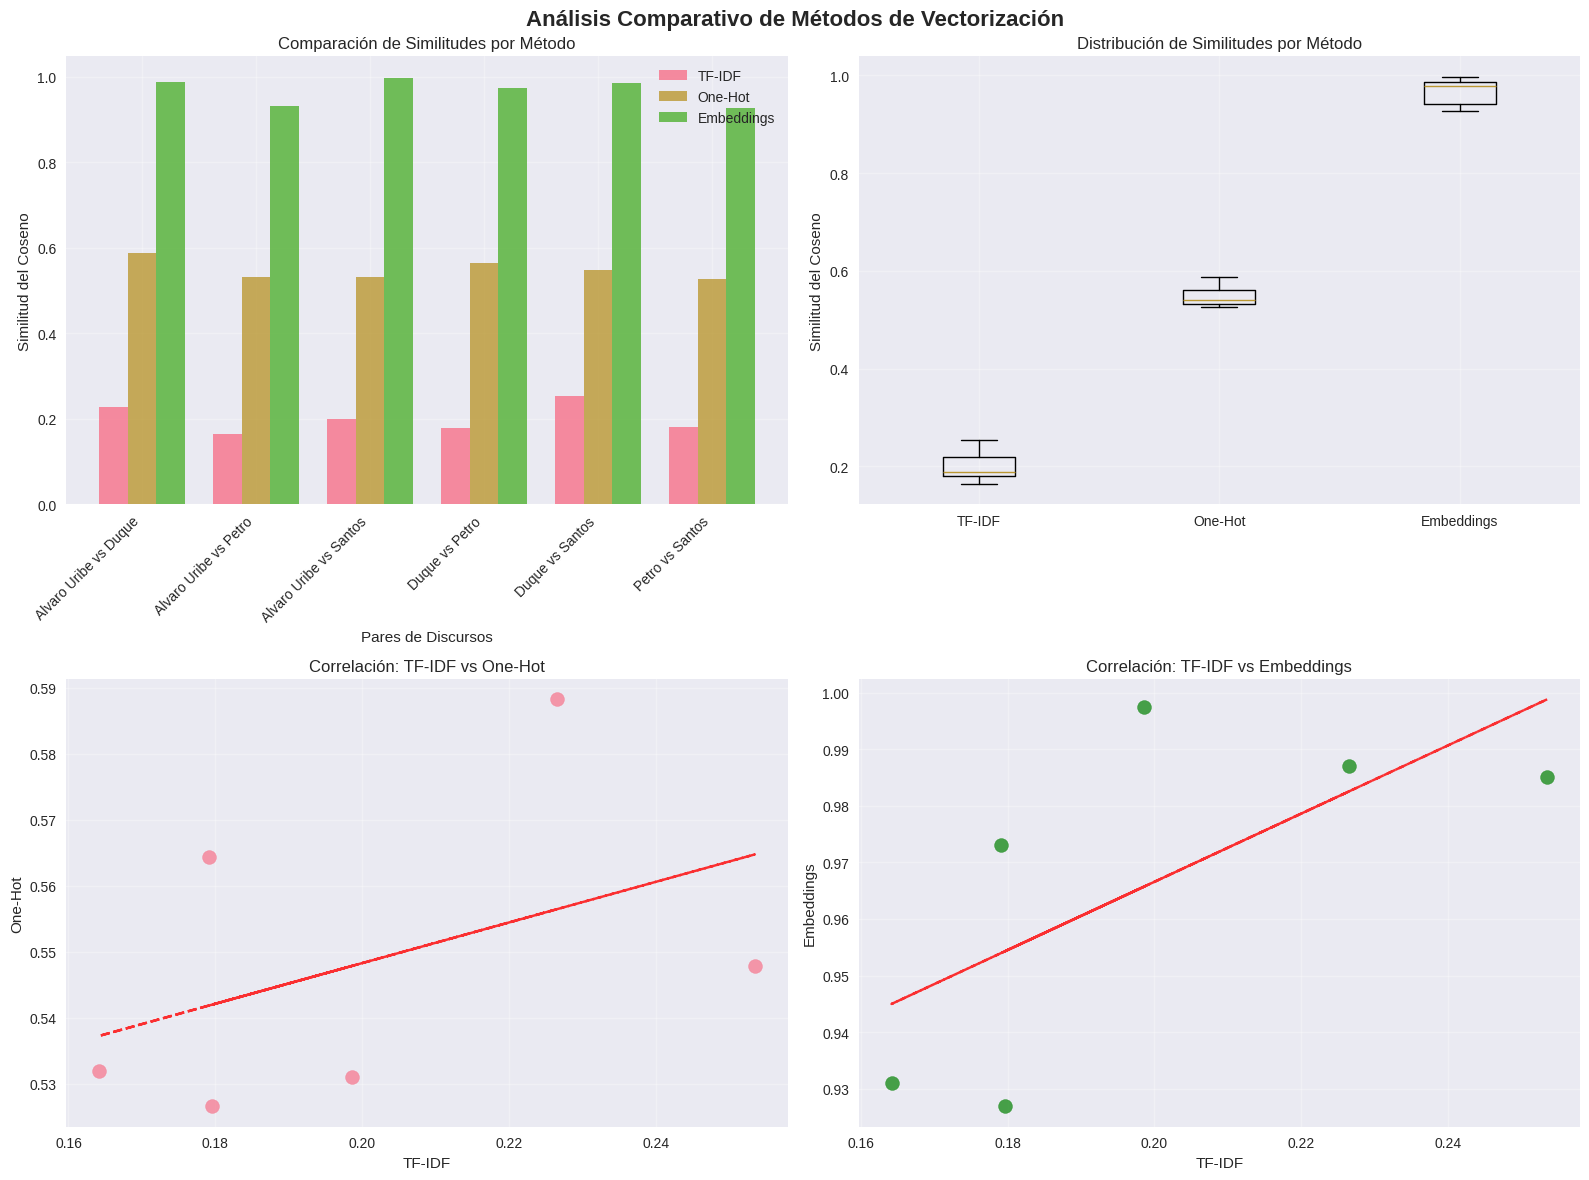

In [30]:
# Visualizar comparación
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Comparación directa
x = np.arange(len(pares))
width = 0.25

axes[0,0].bar(x - width, sim_tfidf, width, label='TF-IDF', alpha=0.8)
axes[0,0].bar(x, sim_onehot, width, label='One-Hot', alpha=0.8)
axes[0,0].bar(x + width, sim_embed, width, label='Embeddings', alpha=0.8)

axes[0,0].set_xlabel('Pares de Discursos')
axes[0,0].set_ylabel('Similitud del Coseno')
axes[0,0].set_title('Comparación de Similitudes por Método')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels(pares, rotation=45, ha='right')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Gráfico 2: Distribución de similitudes
metodos = ['TF-IDF', 'One-Hot', 'Embeddings']
similitudes_all = [sim_tfidf, sim_onehot, sim_embed]

axes[0,1].boxplot(similitudes_all, labels=metodos)
axes[0,1].set_ylabel('Similitud del Coseno')
axes[0,1].set_title('Distribución de Similitudes por Método')
axes[0,1].grid(True, alpha=0.3)

# Gráfico 3: Correlación entre métodos
axes[1,0].scatter(sim_tfidf, sim_onehot, alpha=0.7, s=100)
axes[1,0].set_xlabel('TF-IDF')
axes[1,0].set_ylabel('One-Hot')
axes[1,0].set_title('Correlación: TF-IDF vs One-Hot')
axes[1,0].grid(True, alpha=0.3)

# Añadir línea de tendencia
z = np.polyfit(sim_tfidf, sim_onehot, 1)
p = np.poly1d(z)
axes[1,0].plot(sim_tfidf, p(sim_tfidf), "r--", alpha=0.8)

# Gráfico 4: TF-IDF vs Embeddings
axes[1,1].scatter(sim_tfidf, sim_embed, alpha=0.7, s=100, color='green')
axes[1,1].set_xlabel('TF-IDF')
axes[1,1].set_ylabel('Embeddings')
axes[1,1].set_title('Correlación: TF-IDF vs Embeddings')
axes[1,1].grid(True, alpha=0.3)

# Línea de tendencia
z2 = np.polyfit(sim_tfidf, sim_embed, 1)
p2 = np.poly1d(z2)
axes[1,1].plot(sim_tfidf, p2(sim_tfidf), "r--", alpha=0.8)

plt.suptitle('Análisis Comparativo de Métodos de Vectorización', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [31]:
print("\n" + "="*70)
print("PASO 14: RESUMEN FINAL Y CONCLUSIONES")
print("="*70)

# Calcular estadísticas generales
print("📈 ESTADÍSTICAS GENERALES:")
print("="*40)

for nombre, stats in palabras_stats.items():
    print(f"\n{nombre}:")
    total_palabras = sum([freq for _, freq in stats['top_20']])
    print(f"  - Palabras únicas: {stats['total_palabras_unicas']}")
    print(f"  - Palabras frecuentes (top 20): {total_palabras}")
    print(f"  - Diversidad léxica: {stats['palabras_una_vez']/stats['total_palabras_unicas']:.2%}")

# Encontrar pares más similares y más diferentes
print(f"\n🔍 ANÁLISIS DE SIMILITUDES:")
print("="*40)

for metodo, similitudes in [("TF-IDF", sim_tfidf), ("One-Hot", sim_onehot), ("Embeddings", sim_embed)]:
    idx_max = np.argmax(similitudes)
    idx_min = np.argmin(similitudes)

    print(f"\n{metodo}:")
    print(f"  - Par más similar: {pares[idx_max]} ({similitudes[idx_max]:.4f})")
    print(f"  - Par menos similar: {pares[idx_min]} ({similitudes[idx_min]:.4f})")
    print(f"  - Similitud promedio: {np.mean(similitudes):.4f}")
    print(f"  - Desviación estándar: {np.std(similitudes):.4f}")

# Correlaciones entre métodos
corr_tfidf_onehot = np.corrcoef(sim_tfidf, sim_onehot)[0,1]
corr_tfidf_embed = np.corrcoef(sim_tfidf, sim_embed)[0,1]
corr_onehot_embed = np.corrcoef(sim_onehot, sim_embed)[0,1]

print(f"\n🔗 CORRELACIONES ENTRE MÉTODOS:")
print("="*40)
print(f"TF-IDF vs One-Hot: {corr_tfidf_onehot:.4f}")
print(f"TF-IDF vs Embeddings: {corr_tfidf_embed:.4f}")
print(f"One-Hot vs Embeddings: {corr_onehot_embed:.4f}")

print(f"\n✅ ANÁLISIS COMPLETADO")
print("="*70)
print("El análisis comparativo de discursos presidenciales ha sido completado exitosamente.")
print("Se han aplicado todos los métodos de vectorización y análisis de similitud solicitados.")
print("Las visualizaciones muestran las diferencias y similitudes entre los discursos de toma de posesión.")

# Crear tabla final resumen
tabla_final = pd.DataFrame({
    'Presidente': [presidentes_info[nombre]['nombre_completo'] for nombre in nombres_ordenados],
    'Archivo': nombres_ordenados,
    'Tokens_Originales': [len(tokens_por_discurso[nombre]) for nombre in nombres_ordenados],
    'Tokens_Sin_StopWords': [len(tokens_sin_stop_words[nombre]) for nombre in nombres_ordenados],
    'Palabras_Unicas': [palabras_stats[presidentes_info[nombre]['nombre_completo']]['total_palabras_unicas']
                       for nombre in nombres_ordenados],
    'Reduccion_Porcentual': [f"{((len(tokens_por_discurso[nombre]) - len(tokens_sin_stop_words[nombre])) / len(tokens_por_discurso[nombre]) * 100):.1f}%"
                            for nombre in nombres_ordenados]
})

print(f"\n📊 TABLA RESUMEN FINAL:")
print("="*80)
print(tabla_final.to_string(index=False))

print(f"\nPara ejecutar este código:")
print("1. Instala las dependencias: pip install pandas numpy matplotlib seaborn nltk spacy transformers torch wordcloud pillow scikit-learn scipy PyPDF2 pdfplumber PyMuPDF")
print("2. Descarga el modelo de spacy: python -m spacy download es_core_news_sm")
print("3. Asegúrate de tener el archivo 'Discursos Presidenciales.zip' en la ruta especificada")
print("4. Ejecuta el script completo paso a paso")

print(f"\n🎉 ¡Análisis de discursos presidenciales completado exitosamente!")


PASO 14: RESUMEN FINAL Y CONCLUSIONES
📈 ESTADÍSTICAS GENERALES:

Álvaro Uribe Vélez:
  - Palabras únicas: 1465
  - Palabras frecuentes (top 20): 201
  - Diversidad léxica: 77.13%

Iván Duque Márquez:
  - Palabras únicas: 1401
  - Palabras frecuentes (top 20): 289
  - Diversidad léxica: 73.45%

Gustavo Petro Urrego:
  - Palabras únicas: 1121
  - Palabras frecuentes (top 20): 256
  - Diversidad léxica: 72.52%

Juan Manuel Santos:
  - Palabras únicas: 1059
  - Palabras frecuentes (top 20): 238
  - Diversidad léxica: 74.50%

🔍 ANÁLISIS DE SIMILITUDES:

TF-IDF:
  - Par más similar: Duque vs Santos (0.2535)
  - Par menos similar: Alvaro Uribe vs Petro (0.1642)
  - Similitud promedio: 0.2003
  - Desviación estándar: 0.0308

One-Hot:
  - Par más similar: Alvaro Uribe vs Duque (0.5883)
  - Par menos similar: Petro vs Santos (0.5266)
  - Similitud promedio: 0.5484
  - Desviación estándar: 0.0219

Embeddings:
  - Par más similar: Alvaro Uribe vs Santos (0.9974)
  - Par menos similar: Petro vs Sa

In [32]:
# PASO 15: REPRESENTACIÓN GLOBAL DE DOCUMENTOS COMPLETOS
# ============================================================================

print("\n" + "="*70)
print("PASO 15: REPRESENTACIÓN GLOBAL DE DOCUMENTOS COMPLETOS")
print("="*70)

def crear_perfil_global_documento(vectores, nombres, metodo_nombre):
    """Crea un perfil global para cada documento basado en su vector completo"""

    print(f"\n🌍 Creando perfiles globales - {metodo_nombre}")
    print("="*50)

    # Calcular estadísticas globales por documento
    perfiles = {}

    for i, nombre in enumerate(nombres):
        vector = vectores[i]

        perfil = {
            'nombre': presidentes_info[nombre]['nombre_completo'],
            'magnitud': np.linalg.norm(vector),  # Magnitud del vector
            'densidad': np.count_nonzero(vector) / len(vector),  # % de componentes no-cero
            'media': np.mean(vector),
            'std': np.std(vector),
            'max_val': np.max(vector),
            'min_val': np.min(vector),
            'energia': np.sum(vector**2),  # Energía del vector
            'entropia': -np.sum(vector[vector > 0] * np.log(vector[vector > 0] + 1e-10)) if np.any(vector > 0) else 0,
            'vector_completo': vector
        }

        perfiles[nombre] = perfil

        print(f"\n{perfil['nombre']}:")
        print(f"  • Magnitud del vector: {perfil['magnitud']:.4f}")
        print(f"  • Densidad (% no-cero): {perfil['densidad']:.1%}")
        print(f"  • Valor promedio: {perfil['media']:.4f}")
        print(f"  • Desviación estándar: {perfil['std']:.4f}")
        print(f"  • Energía total: {perfil['energia']:.4f}")
        print(f"  • Entropía: {perfil['entropia']:.4f}")

    return perfiles

def visualizar_perfiles_globales(perfiles_tfidf, perfiles_onehot, perfiles_embed):
    """Visualiza los perfiles globales de todos los métodos"""

    nombres_presidentes = [perfil['nombre'] for perfil in perfiles_tfidf.values()]

    # Crear figura con subplots
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Perfiles Globales de Documentos por Método de Vectorización',
                 fontsize=18, fontweight='bold')

    # Colores por presidente
    colores = plt.cm.Set3(np.linspace(0, 1, len(nombres_presidentes)))

    # Métodos y perfiles
    metodos = ['TF-IDF', 'One-Hot', 'Embeddings']
    todos_perfiles = [perfiles_tfidf, perfiles_onehot, perfiles_embed]

    # Fila 1: Magnitud de vectores
    for j, (metodo, perfiles) in enumerate(zip(metodos, todos_perfiles)):
        magnitudes = [perfil['magnitud'] for perfil in perfiles.values()]

        bars = axes[0,j].bar(range(len(nombres_presidentes)), magnitudes,
                            color=colores, alpha=0.8)
        axes[0,j].set_title(f'Magnitud de Vectores - {metodo}')
        axes[0,j].set_ylabel('Magnitud')
        axes[0,j].set_xticks(range(len(nombres_presidentes)))
        axes[0,j].set_xticklabels([name.split()[-1] for name in nombres_presidentes],
                                 rotation=45)

        # Añadir valores en las barras
        for bar, mag in zip(bars, magnitudes):
            height = bar.get_height()
            axes[0,j].text(bar.get_x() + bar.get_width()/2., height,
                          f'{mag:.2f}', ha='center', va='bottom', fontsize=9)

    # Fila 2: Densidad de vectores
    for j, (metodo, perfiles) in enumerate(zip(metodos, todos_perfiles)):
        densidades = [perfil['densidad'] * 100 for perfil in perfiles.values()]

        bars = axes[1,j].bar(range(len(nombres_presidentes)), densidades,
                            color=colores, alpha=0.8)
        axes[1,j].set_title(f'Densidad de Vectores - {metodo}')
        axes[1,j].set_ylabel('Densidad (%)')
        axes[1,j].set_xticks(range(len(nombres_presidentes)))
        axes[1,j].set_xticklabels([name.split()[-1] for name in nombres_presidentes],
                                 rotation=45)

        for bar, dens in zip(bars, densidades):
            height = bar.get_height()
            axes[1,j].text(bar.get_x() + bar.get_width()/2., height,
                          f'{dens:.1f}%', ha='center', va='bottom', fontsize=9)

    # Fila 3: Energía de vectores
    for j, (metodo, perfiles) in enumerate(zip(metodos, todos_perfiles)):
        energias = [perfil['energia'] for perfil in perfiles.values()]

        bars = axes[2,j].bar(range(len(nombres_presidentes)), energias,
                            color=colores, alpha=0.8)
        axes[2,j].set_title(f'Energía de Vectores - {metodo}')
        axes[2,j].set_ylabel('Energía')
        axes[2,j].set_xticks(range(len(nombres_presidentes)))
        axes[2,j].set_xticklabels([name.split()[-1] for name in nombres_presidentes],
                                 rotation=45)

        for bar, energia in zip(bars, energias):
            height = bar.get_height()
            axes[2,j].text(bar.get_x() + bar.get_width()/2., height,
                          f'{energia:.1f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

def crear_radar_chart_global(perfiles_dict, metodo_nombre):
    """Crea un gráfico radar para mostrar el perfil global de cada presidente"""

    from math import pi

    nombres_presidentes = [perfil['nombre'] for perfil in perfiles_dict.values()]

    # Normalizar métricas para el radar (0-1)
    metricas = ['magnitud', 'densidad', 'energia', 'std']
    nombres_metricas = ['Magnitud', 'Densidad', 'Energía', 'Variabilidad']

    # Extraer valores y normalizar
    valores_norm = {}
    for metrica in metricas:
        valores = [perfil[metrica] for perfil in perfiles_dict.values()]
        max_val = max(valores)
        min_val = min(valores)

        if max_val > min_val:
            valores_norm[metrica] = [(v - min_val) / (max_val - min_val) for v in valores]
        else:
            valores_norm[metrica] = [0.5] * len(valores)

    # Crear gráfico radar
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

    # Ángulos para cada métrica
    angulos = [n / float(len(metricas)) * 2 * pi for n in range(len(metricas))]
    angulos += angulos[:1]  # Completar el círculo

    # Colores para cada presidente
    colores_radar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

    # Graficar cada presidente
    for i, nombre_archivo in enumerate(perfiles_dict.keys()):
        perfil = perfiles_dict[nombre_archivo]
        valores = [valores_norm[metrica][i] for metrica in metricas]
        valores += valores[:1]  # Completar el círculo

        ax.plot(angulos, valores, 'o-', linewidth=2,
               label=perfil['nombre'], color=colores_radar[i % len(colores_radar)])
        ax.fill(angulos, valores, alpha=0.25, color=colores_radar[i % len(colores_radar)])

    # Configurar el gráfico
    ax.set_xticks(angulos[:-1])
    ax.set_xticklabels(nombres_metricas, fontsize=12)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=10)
    ax.grid(True)

    plt.title(f'Perfil Global de Documentos - {metodo_nombre}',
              size=16, fontweight='bold', pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    plt.tight_layout()
    plt.show()

def crear_mapa_calor_documentos_completos(vectores, nombres, metodo_nombre, top_n=50):
    """Crea un mapa de calor mostrando los documentos completos"""

    # Seleccionar top N características más importantes
    if vectores.shape[1] > top_n:
        # Calcular importancia promedio de cada característica
        importancia = np.mean(np.abs(vectores), axis=0)
        top_indices = np.argsort(importancia)[-top_n:][::-1]
        vectores_top = vectores[:, top_indices]
    else:
        vectores_top = vectores
        top_indices = range(vectores.shape[1])

    nombres_presidentes = [presidentes_info[nombre]['nombre_completo'] for nombre in nombres]

    plt.figure(figsize=(16, 8))

    # Crear heatmap
    sns.heatmap(vectores_top,
                xticklabels=[f"C_{i}" for i in range(vectores_top.shape[1])],
                yticklabels=nombres_presidentes,
                cmap='RdYlBu_r',
                center=0 if metodo_nombre != 'One-Hot' else 0.5,
                cbar_kws={'label': f'Valor de Característica ({metodo_nombre})'})

    plt.title(f'Representación Global de Documentos Completos - {metodo_nombre}\n'
              f'(Top {vectores_top.shape[1]} características más importantes)',
              fontsize=14, fontweight='bold')
    plt.xlabel('Características')
    plt.ylabel('Documentos Presidenciales')
    plt.tight_layout()
    plt.show()

def analisis_distancias_globales(vectores, nombres):
    """Analiza las distancias globales entre documentos completos"""

    # Calcular diferentes métricas de distancia
    from scipy.spatial.distance import pdist, squareform
    from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances

    # Distancia Euclidiana
    dist_euclidiana = euclidean_distances(vectores)

    # Distancia Manhattan
    dist_manhattan = manhattan_distances(vectores)

    # Distancia del coseno (1 - similitud_coseno)
    sim_coseno = cosine_similarity(vectores)
    dist_coseno = 1 - sim_coseno

    nombres_presidentes = [presidentes_info[nombre]['nombre_completo'] for nombre in nombres]

    # Visualizar todas las distancias
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Distancia Euclidiana
    sns.heatmap(dist_euclidiana,
                xticklabels=[name.split()[-1] for name in nombres_presidentes],
                yticklabels=[name.split()[-1] for name in nombres_presidentes],
                annot=True, fmt='.2f', cmap='Reds', ax=axes[0])
    axes[0].set_title('Distancia Euclidiana\nGlobal entre Documentos')

    # Distancia Manhattan
    sns.heatmap(dist_manhattan,
                xticklabels=[name.split()[-1] for name in nombres_presidentes],
                yticklabels=[name.split()[-1] for name in nombres_presidentes],
                annot=True, fmt='.2f', cmap='Oranges', ax=axes[1])
    axes[1].set_title('Distancia Manhattan\nGlobal entre Documentos')

    # Distancia del Coseno
    sns.heatmap(dist_coseno,
                xticklabels=[name.split()[-1] for name in nombres_presidentes],
                yticklabels=[name.split()[-1] for name in nombres_presidentes],
                annot=True, fmt='.3f', cmap='Blues', ax=axes[2])
    axes[2].set_title('Distancia del Coseno\nGlobal entre Documentos')

    plt.tight_layout()
    plt.show()

    return dist_euclidiana, dist_manhattan, dist_coseno


PASO 15: REPRESENTACIÓN GLOBAL DE DOCUMENTOS COMPLETOS



🔍 Creando perfiles globales para todos los métodos de vectorización...

🌍 Creando perfiles globales - TF-IDF

Álvaro Uribe Vélez:
  • Magnitud del vector: 1.0000
  • Densidad (% no-cero): 48.6%
  • Valor promedio: 0.0176
  • Desviación estándar: 0.0263
  • Energía total: 1.0000
  • Entropía: 54.6231

Iván Duque Márquez:
  • Magnitud del vector: 1.0000
  • Densidad (% no-cero): 54.0%
  • Valor promedio: 0.0182
  • Desviación estándar: 0.0259
  • Energía total: 1.0000
  • Entropía: 57.5888

Gustavo Petro Urrego:
  • Magnitud del vector: 1.0000
  • Densidad (% no-cero): 45.4%
  • Valor promedio: 0.0170
  • Desviación estándar: 0.0267
  • Energía total: 1.0000
  • Entropía: 52.0351

Juan Manuel Santos:
  • Magnitud del vector: 1.0000
  • Densidad (% no-cero): 42.2%
  • Valor promedio: 0.0164
  • Desviación estándar: 0.0270
  • Energía total: 1.0000
  • Entropía: 49.6533

🌍 Creando perfiles globales - One-Hot

Álvaro Uribe Vélez:
  • Magnitud del vector: 24.5357
  • Densidad (% no-cero): 6

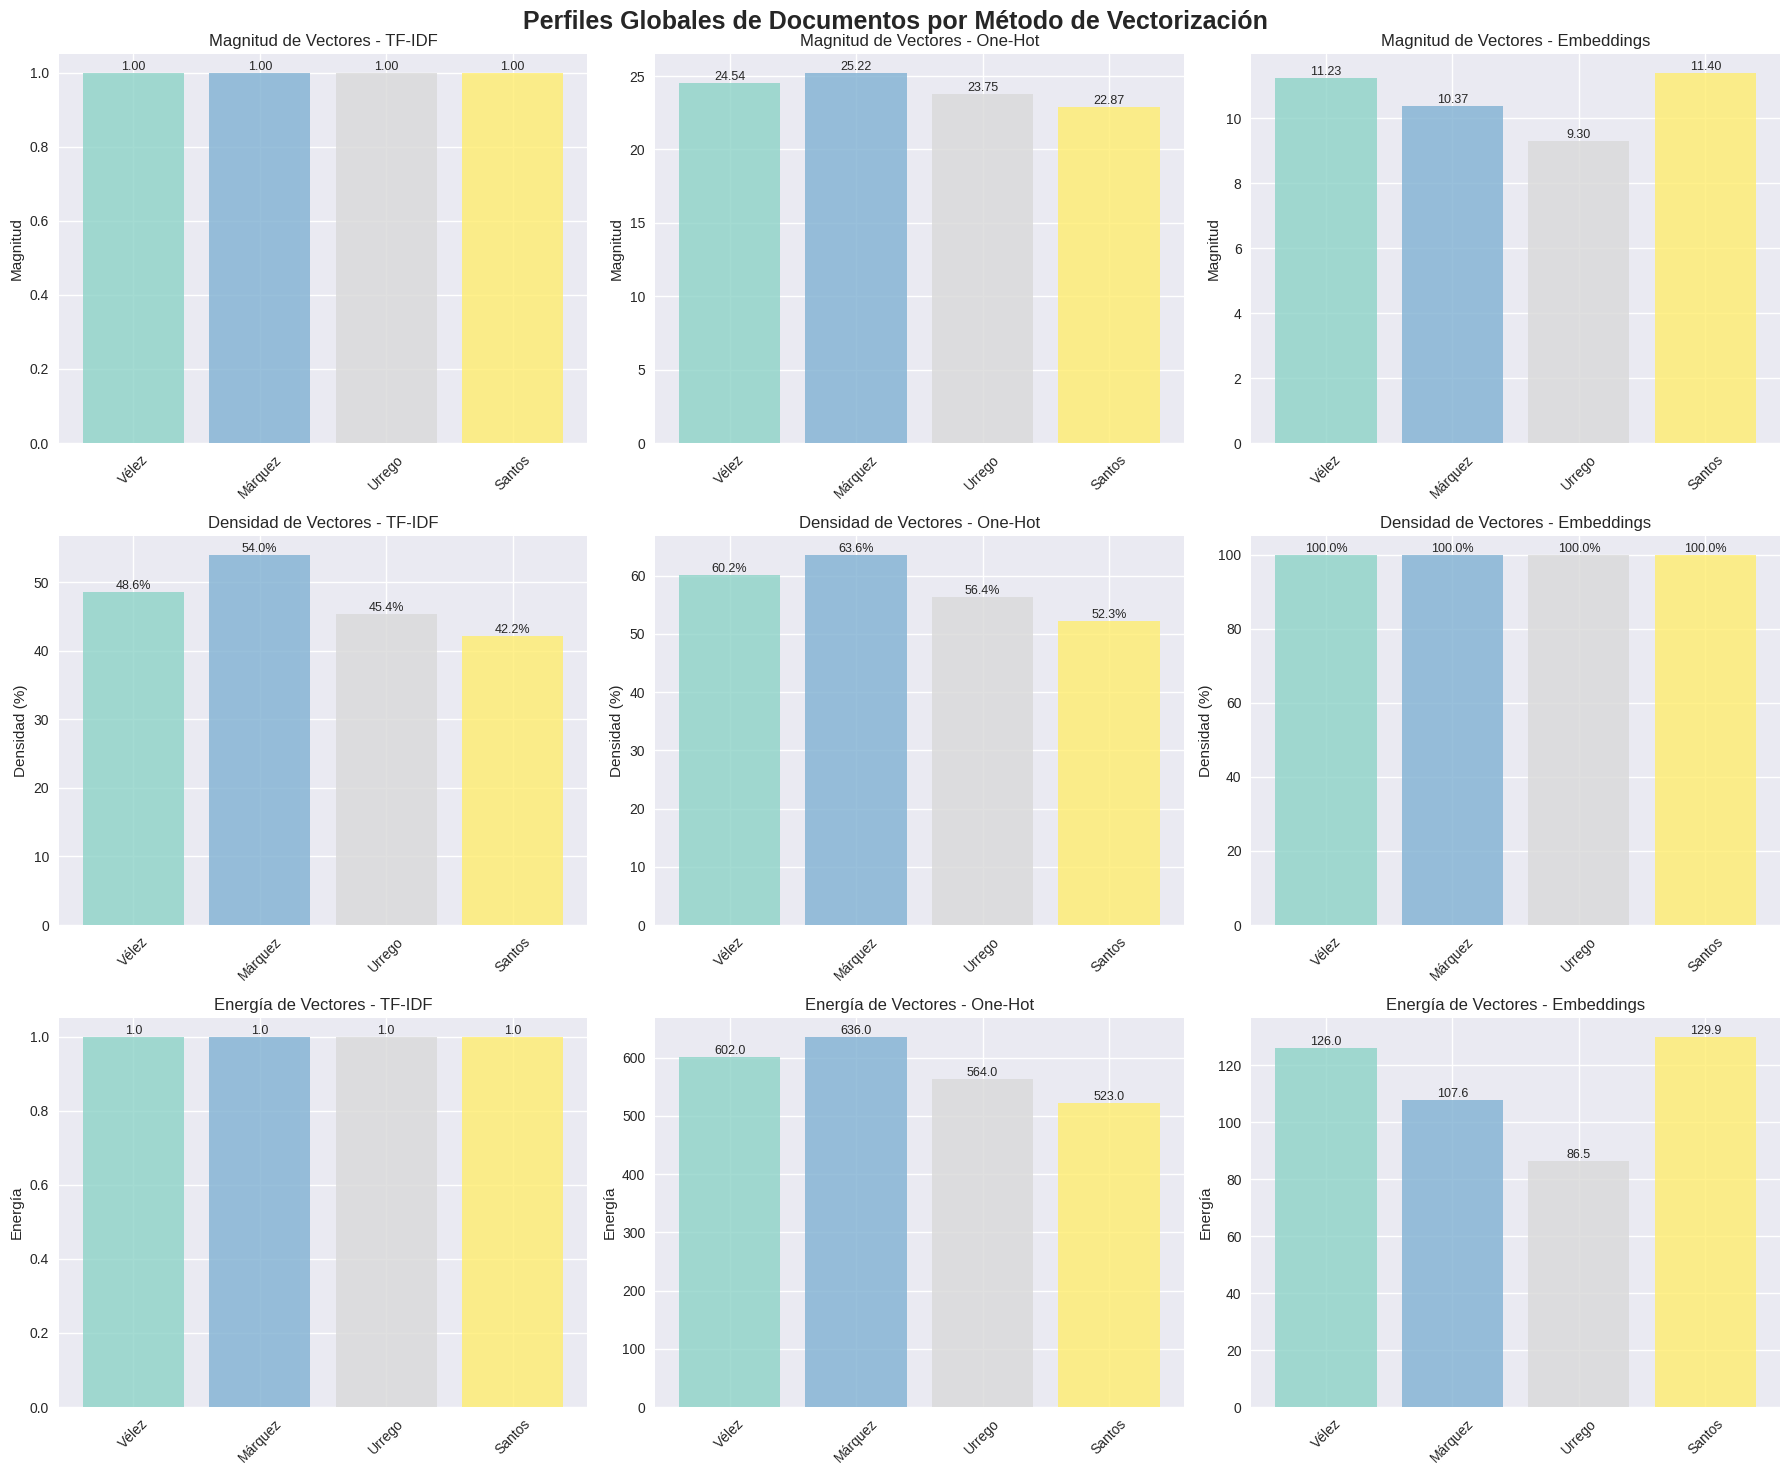


🎯 Creando gráficos radar globales...


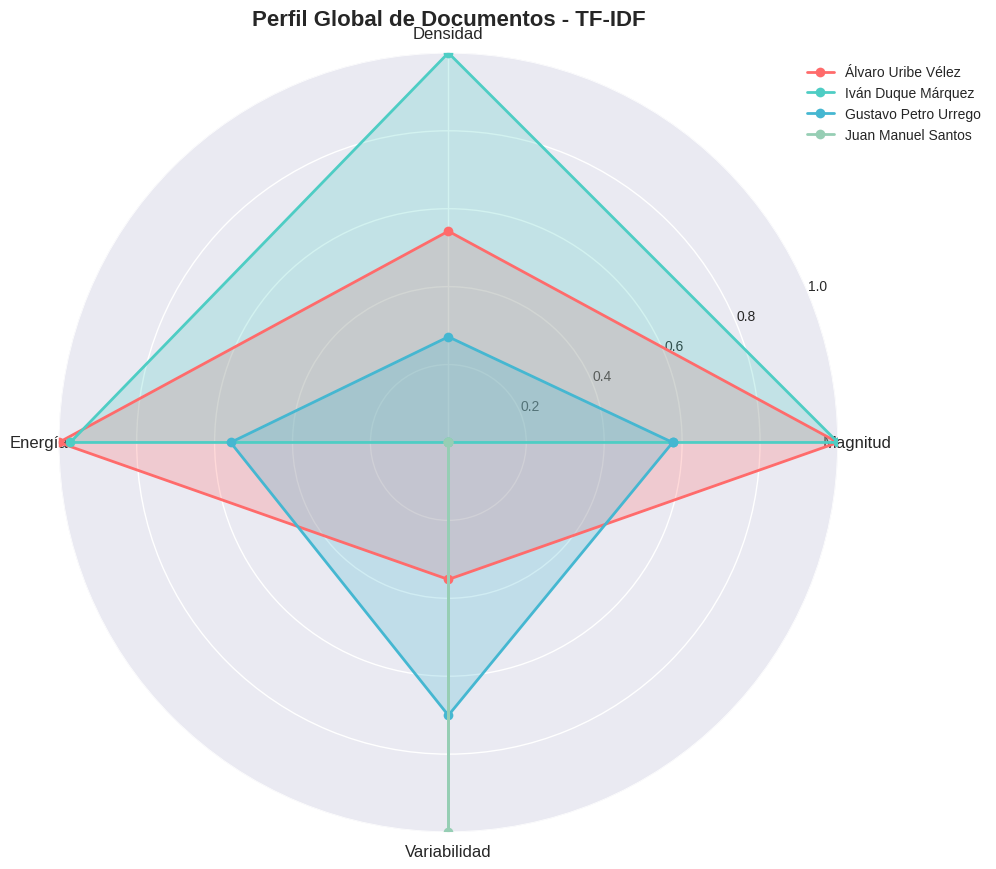

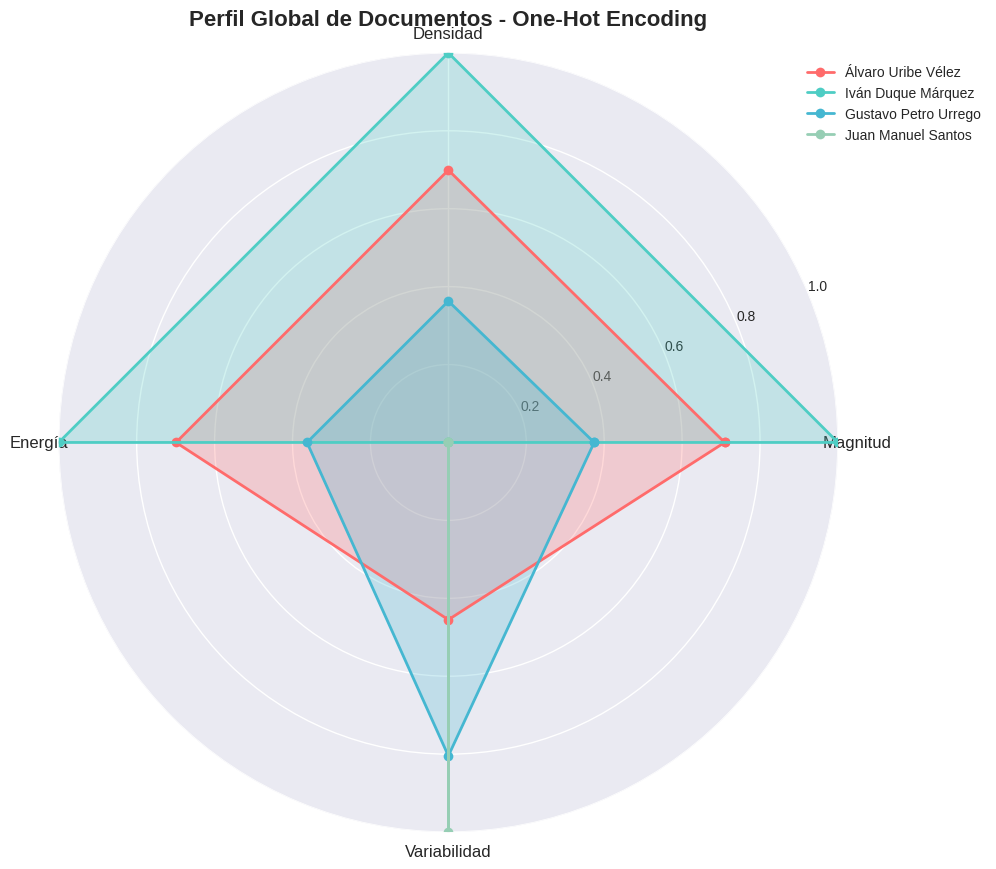

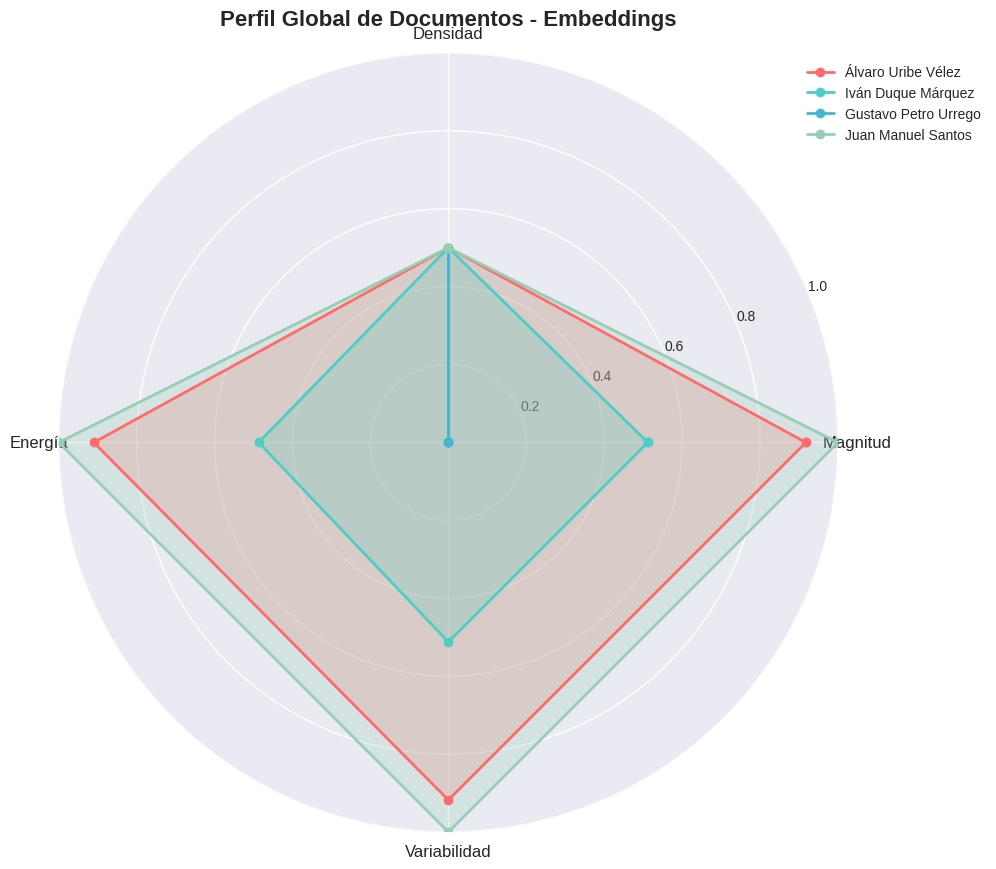


🗺️ Creando mapas de calor de documentos completos...


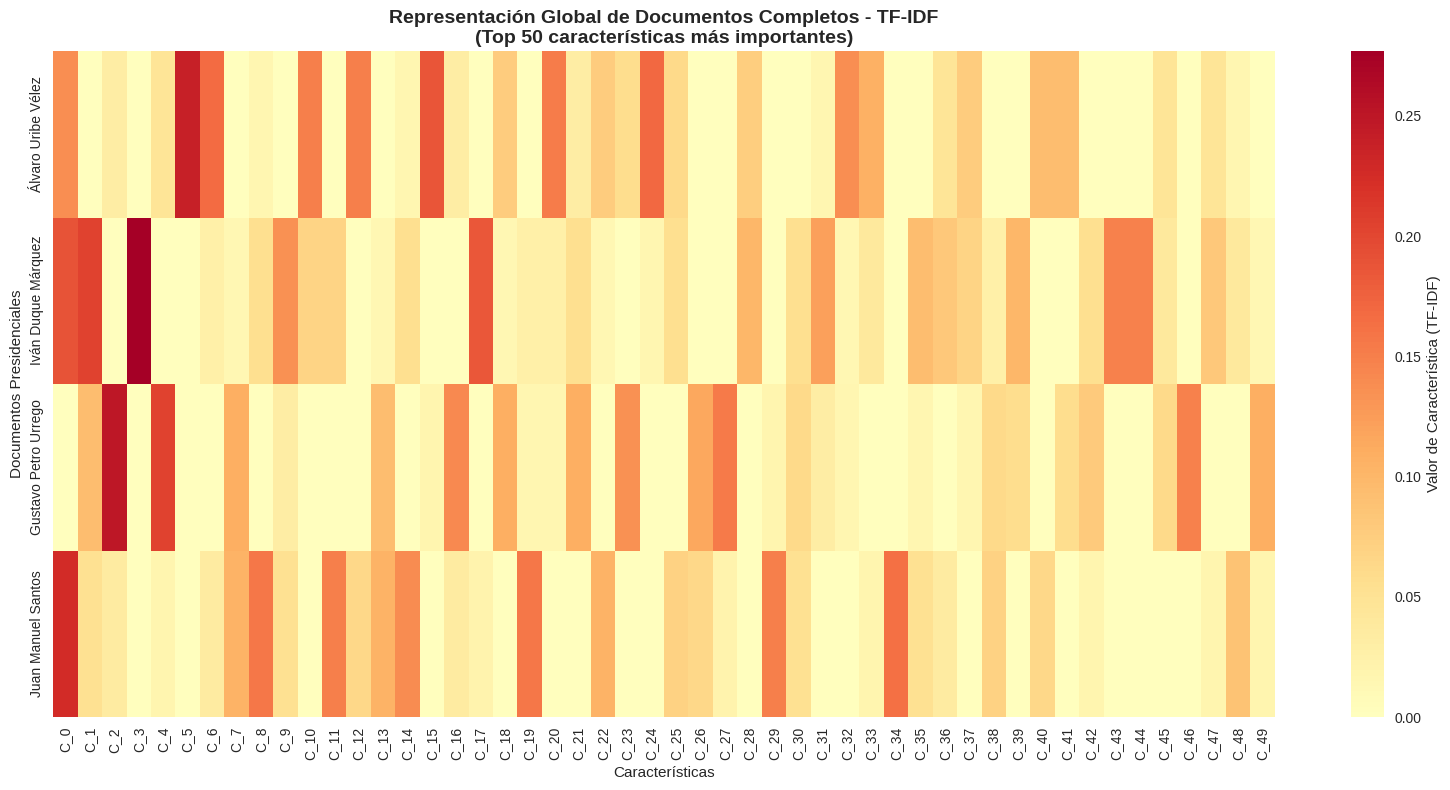

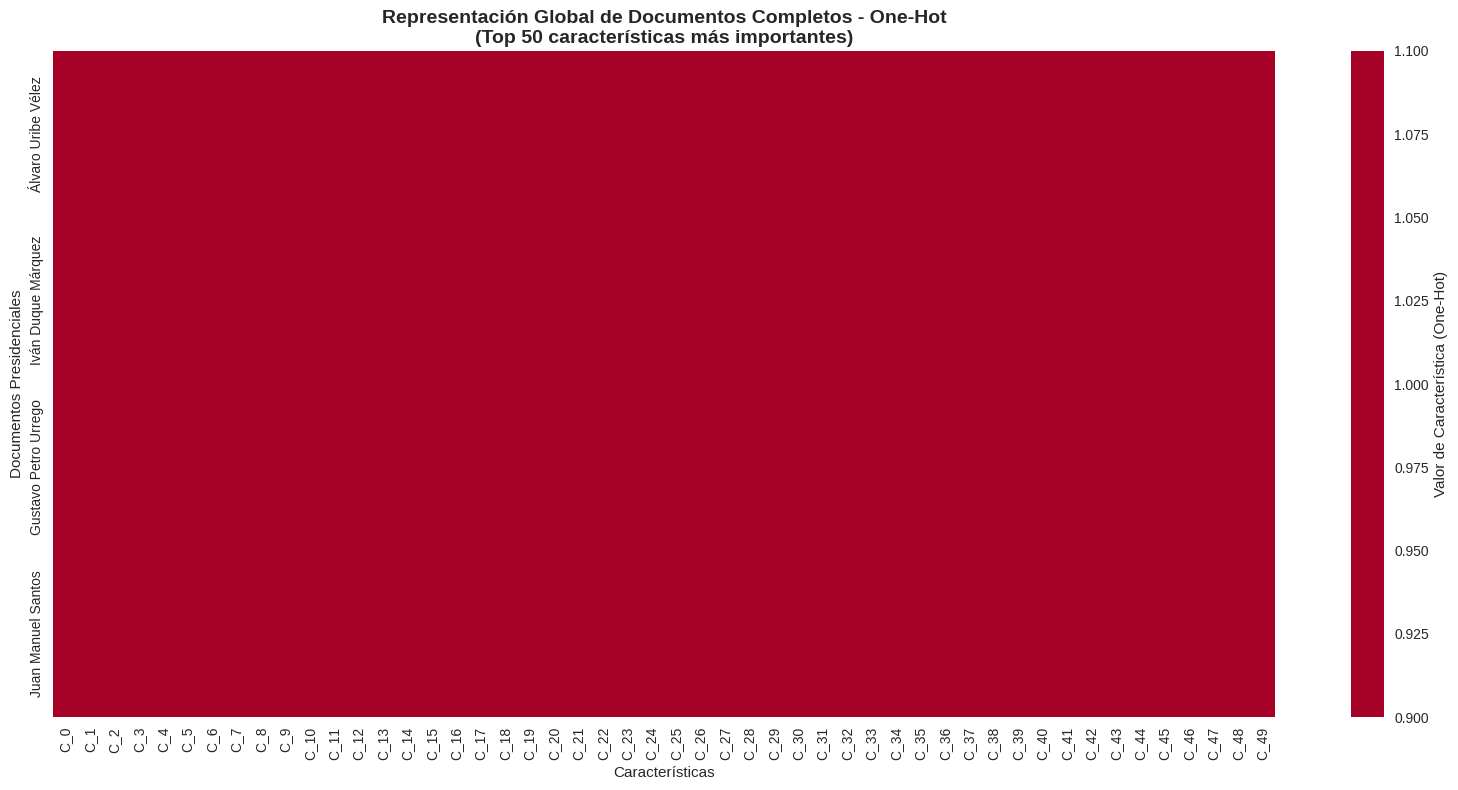

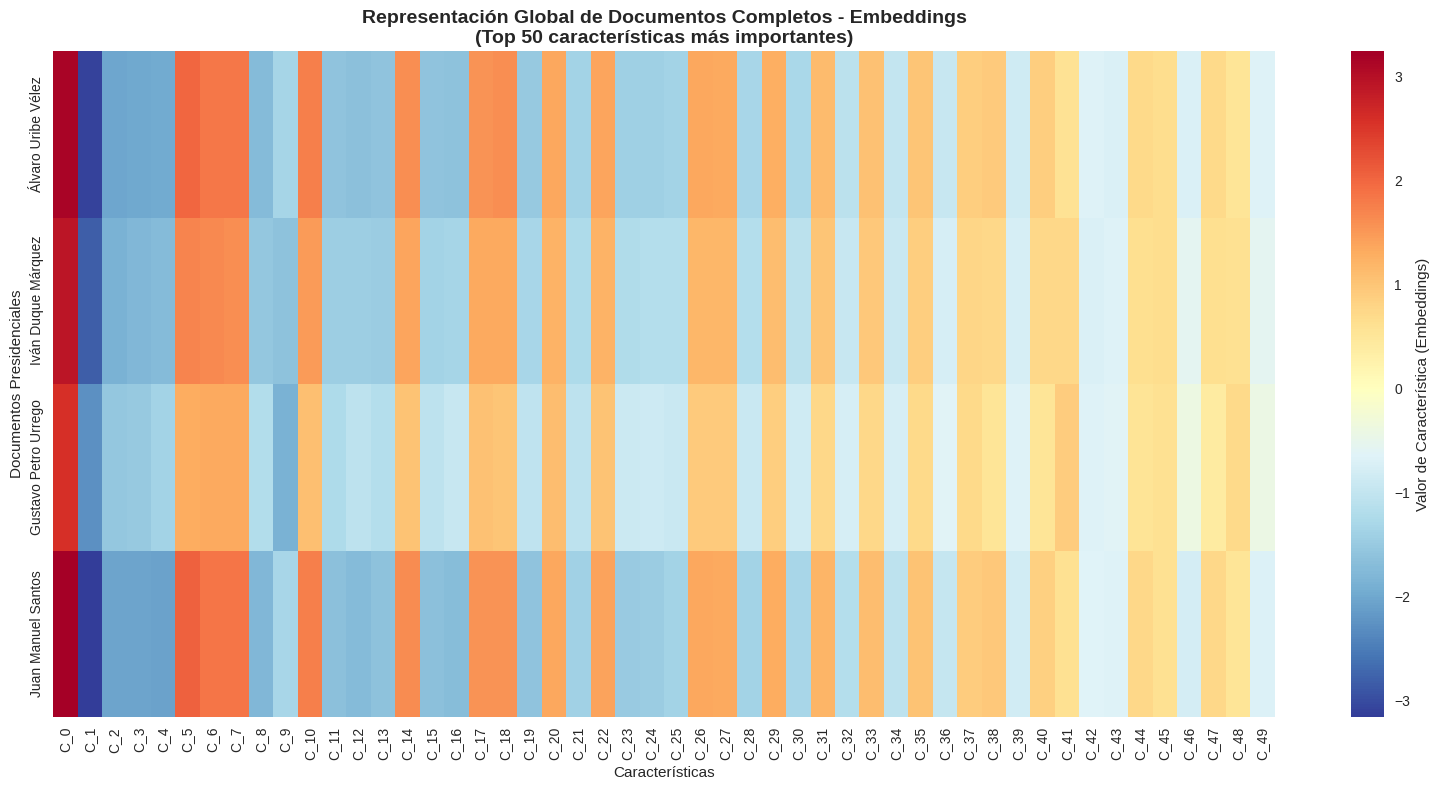


📏 Analizando distancias globales entre documentos completos...

TF-IDF - Distancias Globales:


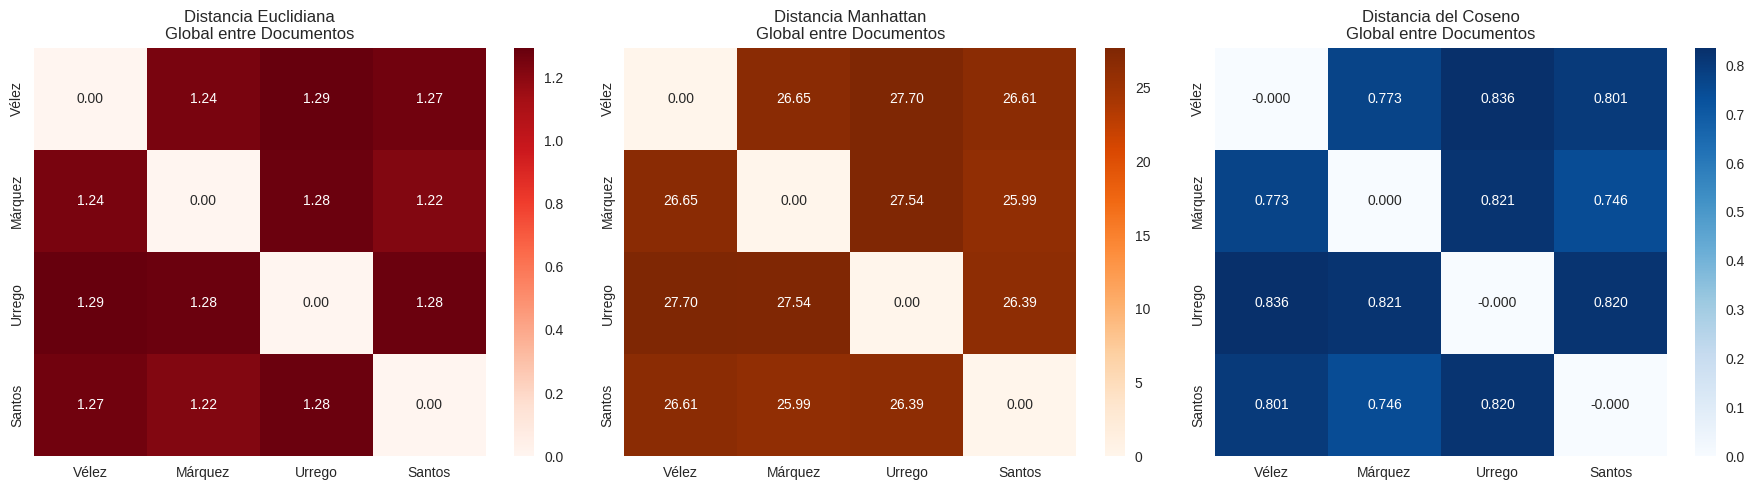


One-Hot - Distancias Globales:


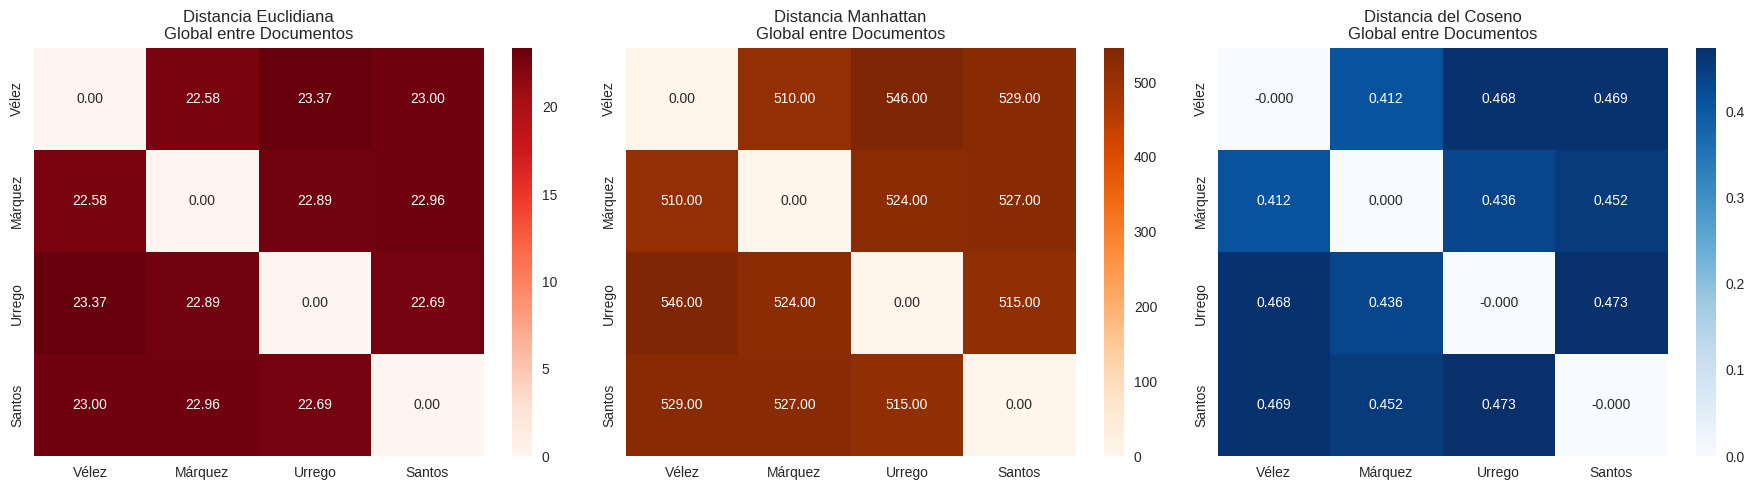


Embeddings - Distancias Globales:


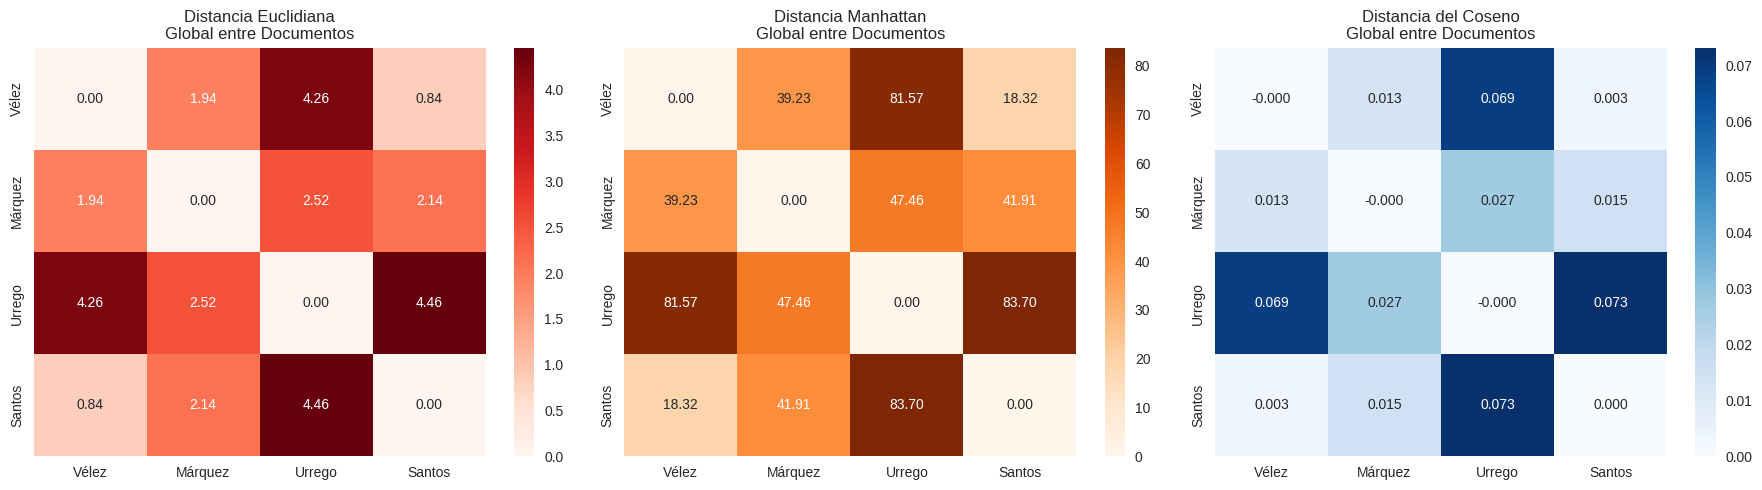


PASO 16: CLUSTERING GLOBAL DE DOCUMENTOS COMPLETOS

🔄 Aplicando clustering global...


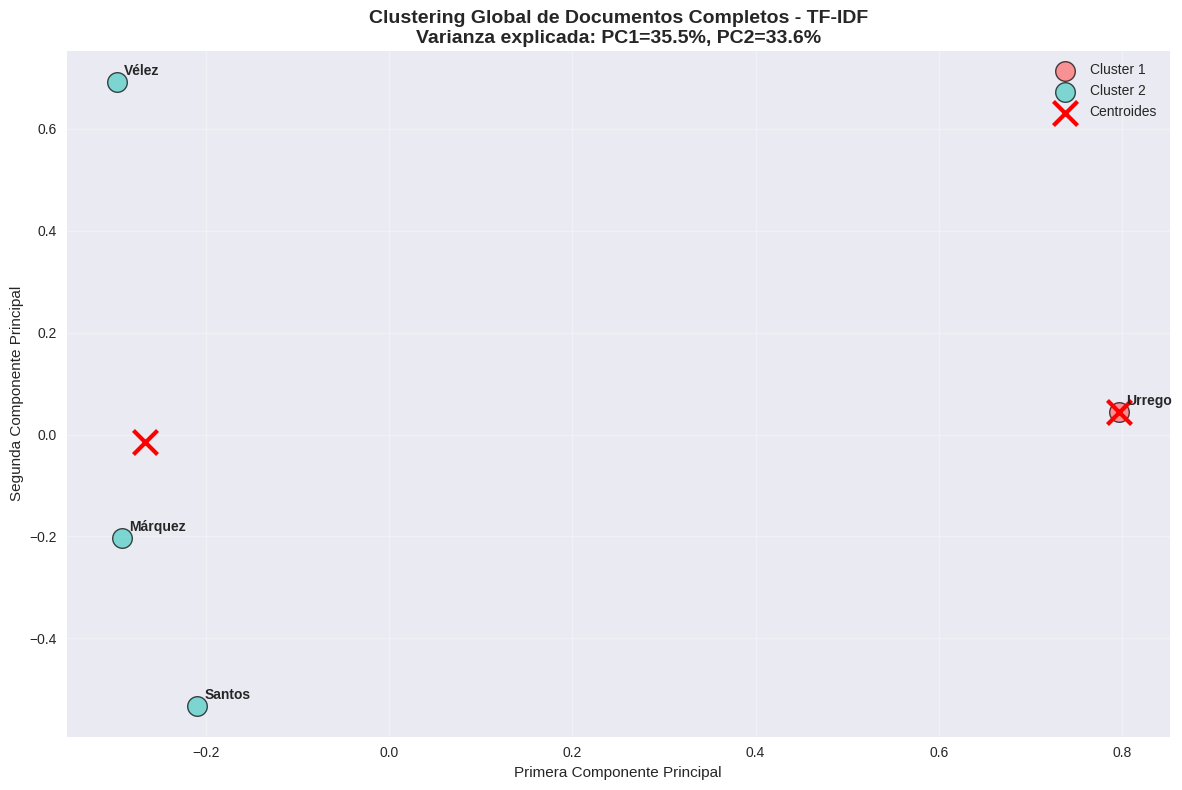


🎯 COMPOSICIÓN DE CLUSTERS - TF-IDF:
Cluster 1: Gustavo Petro Urrego
Cluster 2: Álvaro Uribe Vélez, Iván Duque Márquez, Juan Manuel Santos


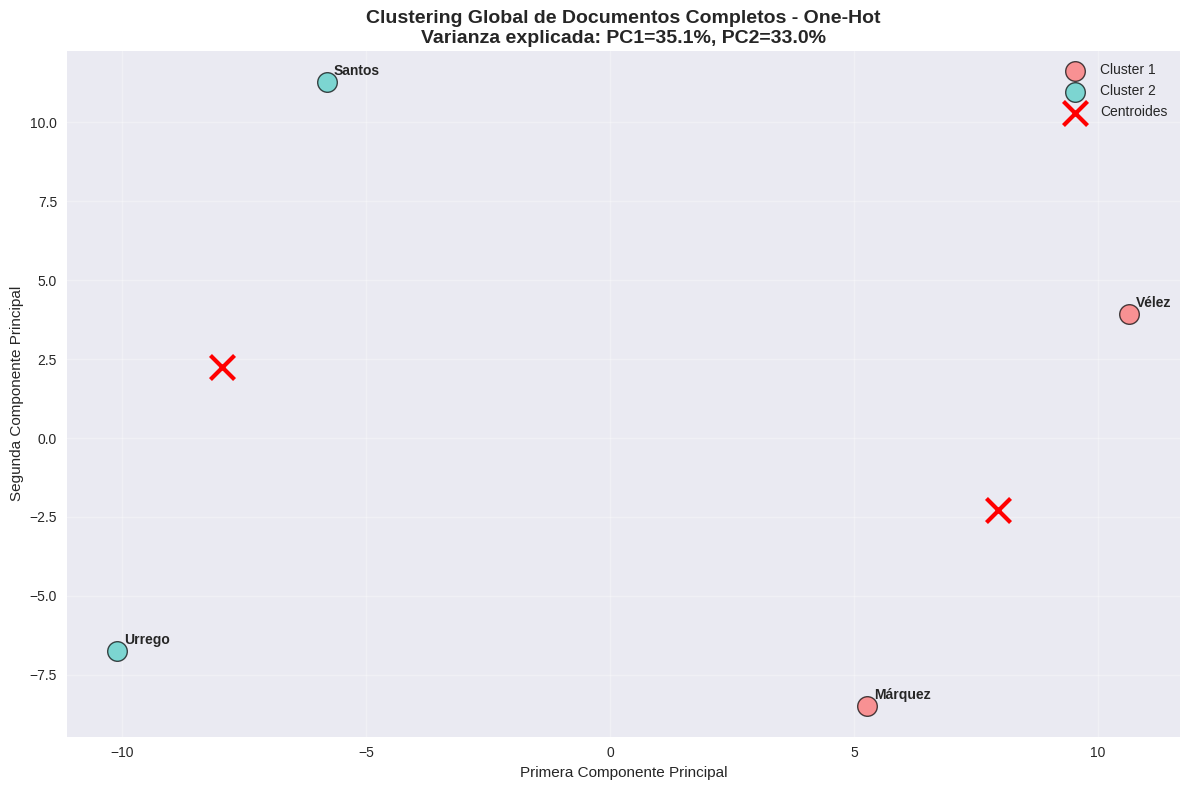


🎯 COMPOSICIÓN DE CLUSTERS - One-Hot:
Cluster 1: Álvaro Uribe Vélez, Iván Duque Márquez
Cluster 2: Gustavo Petro Urrego, Juan Manuel Santos


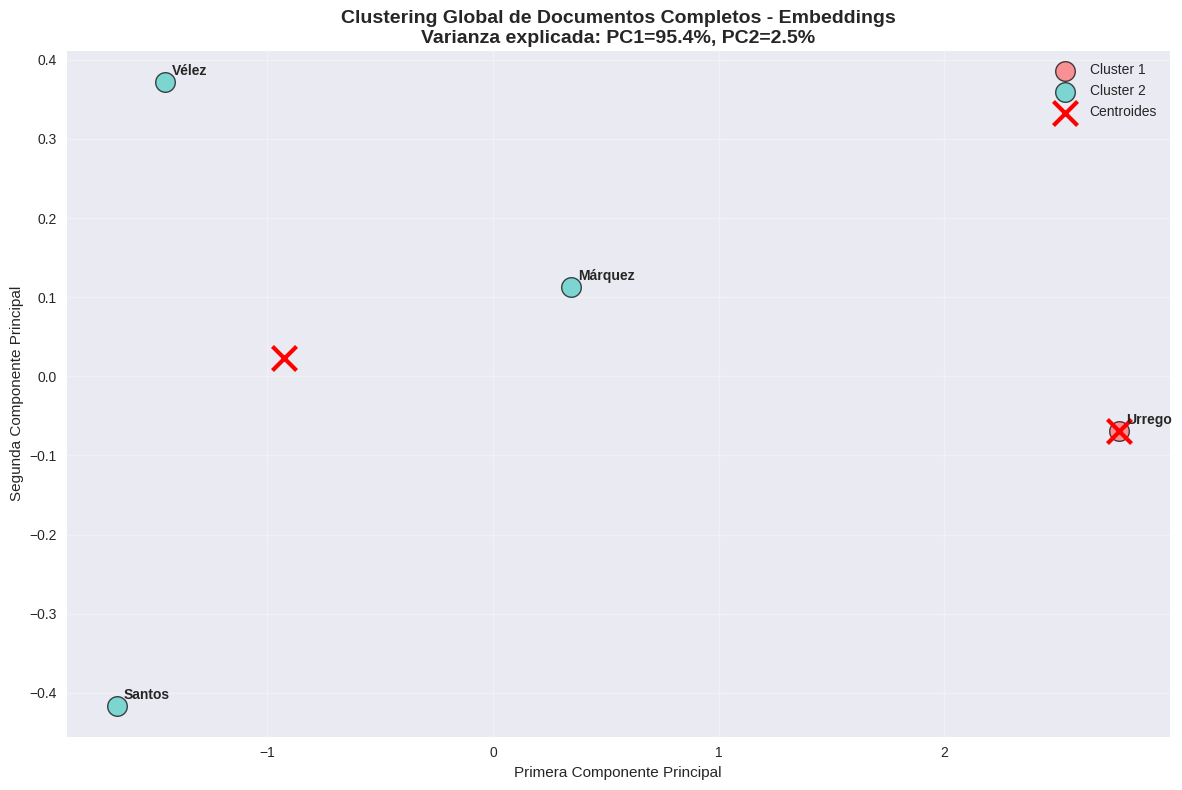


🎯 COMPOSICIÓN DE CLUSTERS - Embeddings:
Cluster 1: Gustavo Petro Urrego
Cluster 2: Álvaro Uribe Vélez, Iván Duque Márquez, Juan Manuel Santos

RESUMEN GLOBAL FINAL - DOCUMENTOS COMPLETOS
📊 TABLA RESUMEN GLOBAL DE DOCUMENTOS COMPLETOS:
          Presidente  Magnitud_TFIDF  Magnitud_OneHot  Magnitud_Embeddings Densidad_TFIDF Densidad_OneHot Cluster_TFIDF Cluster_OneHot Cluster_Embeddings
  Álvaro Uribe Vélez             1.0        24.535688            11.225569          48.6%           60.2%            C2             C1                 C2
  Iván Duque Márquez             1.0        25.219040            10.374720          54.0%           63.6%            C2             C1                 C2
Gustavo Petro Urrego             1.0        23.748684             9.300641          45.4%           56.4%            C1             C2                 C1
  Juan Manuel Santos             1.0        22.869193            11.398032          42.2%           52.3%            C2             C2              

In [33]:
# APLICAR ANÁLISIS GLOBAL A TODOS LOS MÉTODOS
# ============================================================================

print("\n🔍 Creando perfiles globales para todos los métodos de vectorización...")

# Crear perfiles globales
perfiles_tfidf = crear_perfil_global_documento(tfidf_dense, nombres_ordenados, "TF-IDF")
perfiles_onehot = crear_perfil_global_documento(onehot_dense, nombres_ordenados, "One-Hot")
perfiles_embed = crear_perfil_global_documento(embeddings_matrix, nombres_ordenados, "Embeddings")

# Visualizar perfiles globales comparativos
print("\n📊 Creando visualizaciones de perfiles globales...")
visualizar_perfiles_globales(perfiles_tfidf, perfiles_onehot, perfiles_embed)

# Crear gráficos radar para cada método
print("\n🎯 Creando gráficos radar globales...")
crear_radar_chart_global(perfiles_tfidf, "TF-IDF")
crear_radar_chart_global(perfiles_onehot, "One-Hot Encoding")
crear_radar_chart_global(perfiles_embed, "Embeddings")

# Crear mapas de calor de documentos completos
print("\n🗺️ Creando mapas de calor de documentos completos...")
crear_mapa_calor_documentos_completos(tfidf_dense, nombres_ordenados, "TF-IDF")
crear_mapa_calor_documentos_completos(onehot_dense, nombres_ordenados, "One-Hot")
crear_mapa_calor_documentos_completos(embeddings_matrix, nombres_ordenados, "Embeddings")

# Análisis de distancias globales
print("\n📏 Analizando distancias globales entre documentos completos...")

print("\nTF-IDF - Distancias Globales:")
dist_euc_tfidf, dist_man_tfidf, dist_cos_tfidf = analisis_distancias_globales(tfidf_dense, nombres_ordenados)

print("\nOne-Hot - Distancias Globales:")
dist_euc_onehot, dist_man_onehot, dist_cos_onehot = analisis_distancias_globales(onehot_dense, nombres_ordenados)

print("\nEmbeddings - Distancias Globales:")
dist_euc_embed, dist_man_embed, dist_cos_embed = analisis_distancias_globales(embeddings_matrix, nombres_ordenados)

# ============================================================================
# CLUSTERING GLOBAL DE DOCUMENTOS COMPLETOS
# ============================================================================

print("\n" + "="*70)
print("PASO 16: CLUSTERING GLOBAL DE DOCUMENTOS COMPLETOS")
print("="*70)

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.patches as patches

def clustering_global_documentos(vectores, nombres, metodo_nombre, n_clusters=2):
    """Realiza clustering de los documentos completos"""

    # Aplicar K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(vectores)

    # Reducir dimensionalidad para visualización
    if vectores.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        vectores_2d = pca.fit_transform(vectores)
        var_explicada = pca.explained_variance_ratio_
    else:
        vectores_2d = vectores
        var_explicada = [1.0, 0.0]

    nombres_presidentes = [presidentes_info[nombre]['nombre_completo'] for nombre in nombres]

    # Visualizar clustering
    plt.figure(figsize=(12, 8))

    colores_cluster = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

    for i, cluster_id in enumerate(np.unique(clusters)):
        mask = clusters == cluster_id
        plt.scatter(vectores_2d[mask, 0], vectores_2d[mask, 1],
                   c=[colores_cluster[cluster_id]],
                   s=200, alpha=0.7,
                   label=f'Cluster {cluster_id + 1}',
                   edgecolors='black', linewidths=1)

        # Añadir nombres
        for j, nombre in enumerate(nombres):
            if mask[j]:
                plt.annotate(presidentes_info[nombre]['nombre_completo'].split()[-1],
                           (vectores_2d[j, 0], vectores_2d[j, 1]),
                           xytext=(5, 5), textcoords='offset points',
                           fontsize=10, fontweight='bold')

    # Marcar centroides
    centroides_2d = pca.transform(kmeans.cluster_centers_) if vectores.shape[1] > 2 else kmeans.cluster_centers_
    plt.scatter(centroides_2d[:, 0], centroides_2d[:, 1],
               c='red', marker='x', s=300, linewidths=3, label='Centroides')

    plt.title(f'Clustering Global de Documentos Completos - {metodo_nombre}\n'
              f'Varianza explicada: PC1={var_explicada[0]:.1%}, PC2={var_explicada[1]:.1%}',
              fontsize=14, fontweight='bold')
    plt.xlabel('Primera Componente Principal')
    plt.ylabel('Segunda Componente Principal')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Mostrar composición de clusters
    print(f"\n🎯 COMPOSICIÓN DE CLUSTERS - {metodo_nombre}:")
    print("="*50)
    for cluster_id in np.unique(clusters):
        presidentes_en_cluster = [presidentes_info[nombres[i]]['nombre_completo']
                                for i, c in enumerate(clusters) if c == cluster_id]
        print(f"Cluster {cluster_id + 1}: {', '.join(presidentes_en_cluster)}")

    return clusters, kmeans

# Aplicar clustering a todos los métodos
print("\n🔄 Aplicando clustering global...")

clusters_tfidf, kmeans_tfidf = clustering_global_documentos(tfidf_dense, nombres_ordenados, "TF-IDF")
clusters_onehot, kmeans_onehot = clustering_global_documentos(onehot_dense, nombres_ordenados, "One-Hot")
clusters_embed, kmeans_embed = clustering_global_documentos(embeddings_matrix, nombres_ordenados, "Embeddings")

# ============================================================================
# RESUMEN GLOBAL FINAL
# ============================================================================

print("\n" + "="*70)
print("RESUMEN GLOBAL FINAL - DOCUMENTOS COMPLETOS")
print("="*70)

# Crear tabla resumen global
nombres_presidentes = [presidentes_info[nombre]['nombre_completo'] for nombre in nombres_ordenados]

tabla_global = pd.DataFrame({
    'Presidente': nombres_presidentes,
    'Magnitud_TFIDF': [perfiles_tfidf[nombre]['magnitud'] for nombre in nombres_ordenados],
    'Magnitud_OneHot': [perfiles_onehot[nombre]['magnitud'] for nombre in nombres_ordenados],
    'Magnitud_Embeddings': [perfiles_embed[nombre]['magnitud'] for nombre in nombres_ordenados],
    'Densidad_TFIDF': [f"{perfiles_tfidf[nombre]['densidad']:.1%}" for nombre in nombres_ordenados],
    'Densidad_OneHot': [f"{perfiles_onehot[nombre]['densidad']:.1%}" for nombre in nombres_ordenados],
    'Cluster_TFIDF': [f"C{clusters_tfidf[i]+1}" for i in range(len(nombres_ordenados))],
    'Cluster_OneHot': [f"C{clusters_onehot[i]+1}" for i in range(len(nombres_ordenados))],
    'Cluster_Embeddings': [f"C{clusters_embed[i]+1}" for i in range(len(nombres_ordenados))]
})

print("📊 TABLA RESUMEN GLOBAL DE DOCUMENTOS COMPLETOS:")
print("="*120)
print(tabla_global.to_string(index=False))

# Identificar el presidente más "característico" de cada método
print(f"\n🏆 PRESIDENTES MÁS CARACTERÍSTICOS POR MÉTODO:")
print("="*60)

# Basado en magnitud de vector (representatividad)
max_tfidf = max(perfiles_tfidf.values(), key=lambda x: x['magnitud'])
max_onehot = max(perfiles_onehot.values(), key=lambda x: x['magnitud'])
max_embed = max(perfiles_embed.values(), key=lambda x: x['magnitud'])

print(f"TF-IDF: {max_tfidf['nombre']} (magnitud: {max_tfidf['magnitud']:.4f})")
print(f"One-Hot: {max_onehot['nombre']} (magnitud: {max_onehot['magnitud']:.4f})")
print(f"Embeddings: {max_embed['nombre']} (magnitud: {max_embed['magnitud']:.4f})")

print(f"\n✅ ANÁLISIS GLOBAL DE DOCUMENTOS COMPLETADO")
print("="*70)
print("Se ha realizado un análisis completo de los documentos como entidades globales,")
print("incluyendo perfiles completos, clustering, distancias y representaciones holísticas.")

print(f"\n🎉 ¡ANÁLISIS COMPLETO DE DISCURSOS PRESIDENCIALES FINALIZADO!")